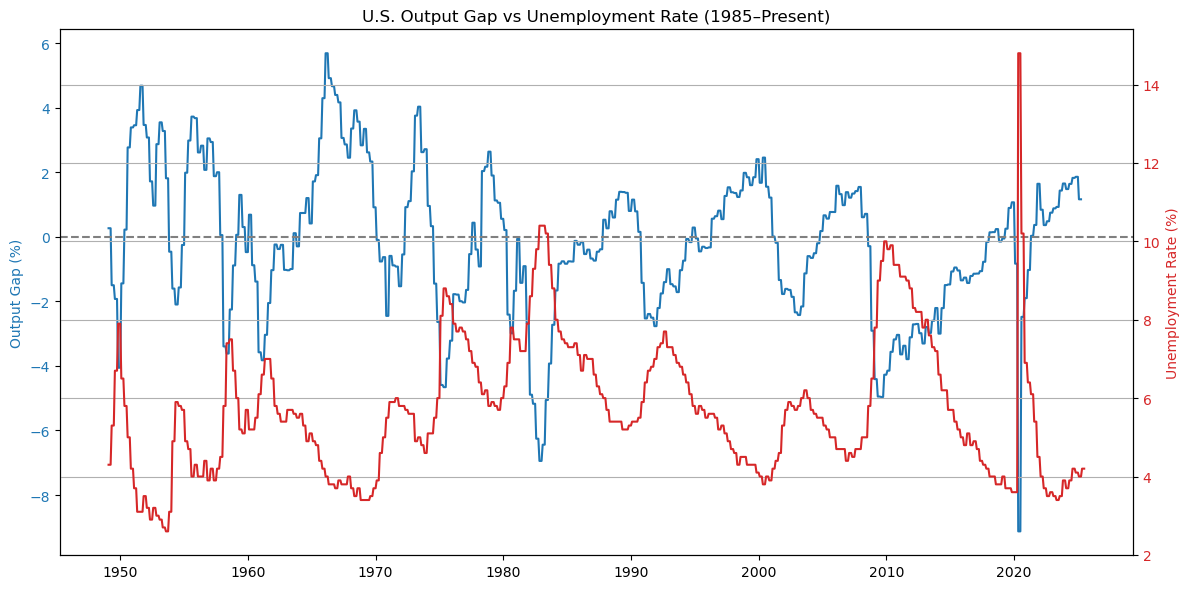

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr

start_date = '1949-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# 下载数据
actual_gdp = pdr.DataReader('GDPC1', 'fred', start_date, end_date)
potential_gdp = pdr.DataReader('GDPPOT', 'fred', start_date, end_date)
unrate = pdr.DataReader('UNRATE', 'fred', start_date, end_date)

# 合并数据
df = pd.concat([actual_gdp, potential_gdp], axis=1)
df.columns = ['Actual_GDP', 'Potential_GDP']
df['Output_Gap'] = 100 * (df['Actual_GDP'] - df['Potential_GDP']) / df['Potential_GDP']
df['Unemployment_Rate'] = unrate

# 转换为月度数据
df_monthly = df.resample('M').ffill()

# 可视化：双轴图
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(df_monthly.index, df_monthly['Output_Gap'], label='Output Gap (%)', color='tab:blue')
ax1.set_ylabel('Output Gap (%)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.axhline(0, color='gray', linestyle='--')

ax2.plot(df_monthly.index, df_monthly['Unemployment_Rate'], label='Unemployment Rate (%)', color='tab:red')
ax2.set_ylabel('Unemployment Rate (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('U.S. Output Gap vs Unemployment Rate (1985–Present)')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()


Okun’s Law
当实际GDP高于潜在GDP（正的产出缺口）时，经济过热，就业上升，失业率下降。
当实际GDP低于潜在GDP（负的产出缺口）时，经济疲软，就业减少，失业率上升。

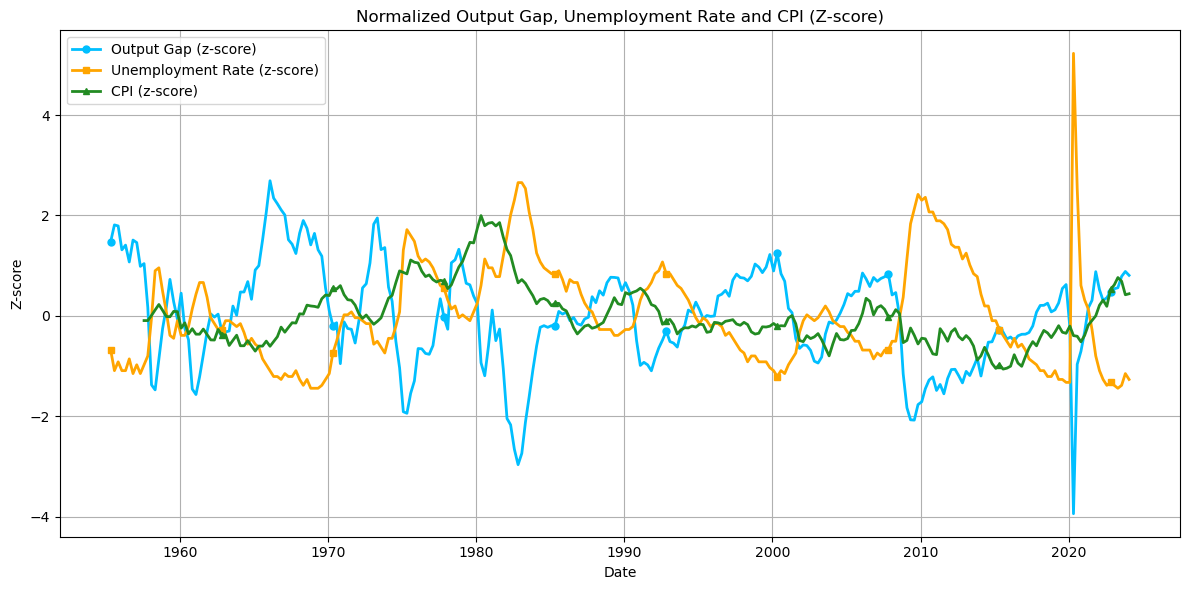

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr
from scipy.stats import zscore

start_date = '1949-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# 下载数据
actual_gdp = pdr.DataReader('GDPC1', 'fred', start_date, end_date)
potential_gdp = pdr.DataReader('GDPPOT', 'fred', start_date, end_date)
unrate = pdr.DataReader('UNRATE', 'fred', start_date, end_date)
cpi = pdr.DataReader('CPALTT01USM657N', 'fred', start_date, end_date)

# 合并数据
df = pd.concat([actual_gdp, potential_gdp, unrate, cpi], axis=1)
df.columns = ['Actual_GDP', 'Potential_GDP', 'Unemployment_Rate', 'CPI']
df['Output_Gap'] = 100 * (df['Actual_GDP'] - df['Potential_GDP']) / df['Potential_GDP']

# 转为月度数据，缺失值向前填充
df_monthly = df.resample('M').ffill().dropna()

# 对三列做 z-score 标准化
df_monthly['Output_Gap_z'] = zscore(df_monthly['Output_Gap'])
df_monthly['Unemployment_Rate_z'] = zscore(df_monthly['Unemployment_Rate'])
df_monthly['CPI_z'] = zscore(df_monthly['CPI'])

# 画图
plt.figure(figsize=(12,6))
plt.plot(df_monthly.index, df_monthly['Output_Gap_z'], label='Output Gap (z-score)',
         color='deepskyblue', linewidth=2, marker='o', markersize=5, markevery=30)
plt.plot(df_monthly.index, df_monthly['Unemployment_Rate_z'], label='Unemployment Rate (z-score)',
         color='orange', linewidth=2, marker='s', markersize=5, markevery=30)
window_size = 10
smoothed_series = df_monthly['CPI_z'].rolling(window=window_size).mean()
plt.plot(df_monthly.index, smoothed_series, label='CPI (z-score)',
         color='forestgreen', linewidth=2, marker='^', markersize=5, markevery=30)
# plt.plot(df_monthly.index, df_monthly['CPI_z'], label='CPI (z-score)',
#          color='forestgreen', linewidth=2, marker='^', markersize=5, markevery=30)

plt.title('Normalized Output Gap, Unemployment Rate and CPI (Z-score)')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


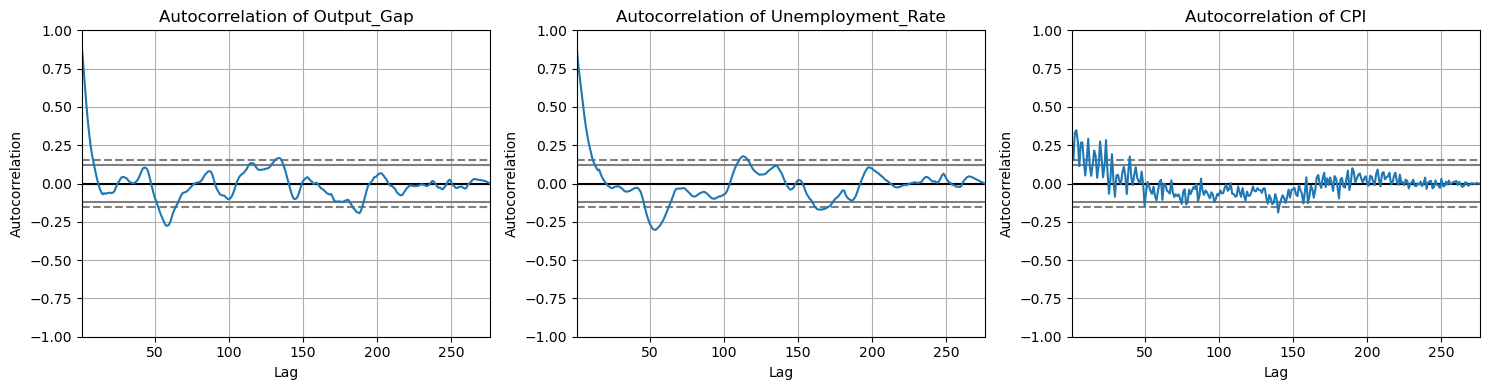

In [3]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(15, 4))
for i, col in enumerate(['Output_Gap', 'Unemployment_Rate', 'CPI']):
    plt.subplot(1, 3, i+1)
    autocorrelation_plot(df_monthly[col])
    plt.title(f'Autocorrelation of {col}')
plt.tight_layout()
plt.show()


使用的是月度数据，横轴表示滞后几期

In [4]:
# 提取需要的列
macro_z = df_monthly[['Output_Gap_z', 'Unemployment_Rate_z', 'CPI_z']]

# 计算相关性矩阵
corr_matrix = macro_z.corr(method='pearson')

# 打印结果
print(corr_matrix)


                     Output_Gap_z  Unemployment_Rate_z     CPI_z
Output_Gap_z             1.000000            -0.821206  0.148171
Unemployment_Rate_z     -0.821206             1.000000 -0.062630
CPI_z                    0.148171            -0.062630  1.000000


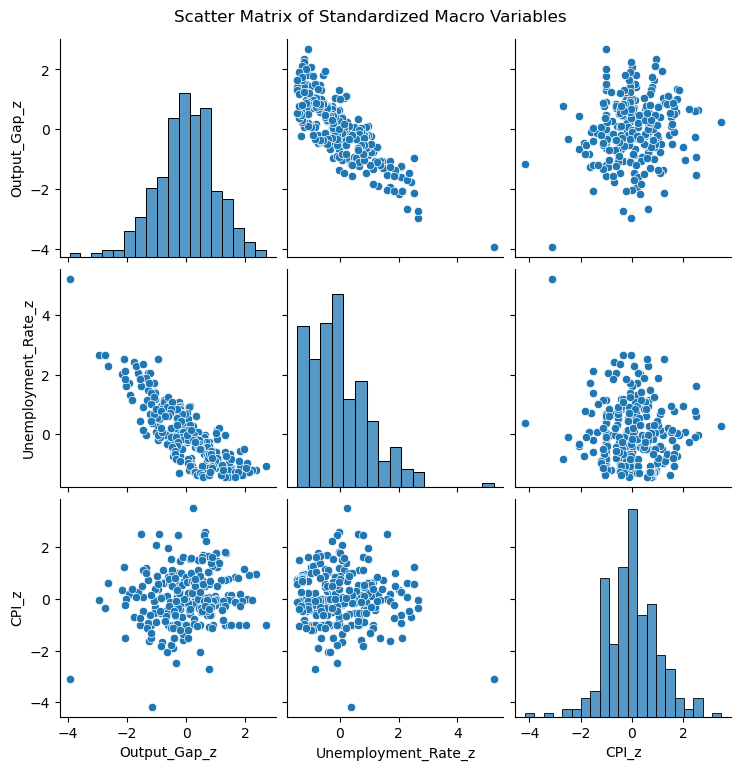

In [5]:
import seaborn as sns

sns.pairplot(macro_z)
plt.suptitle("Scatter Matrix of Standardized Macro Variables", y=1.02)
plt.show()


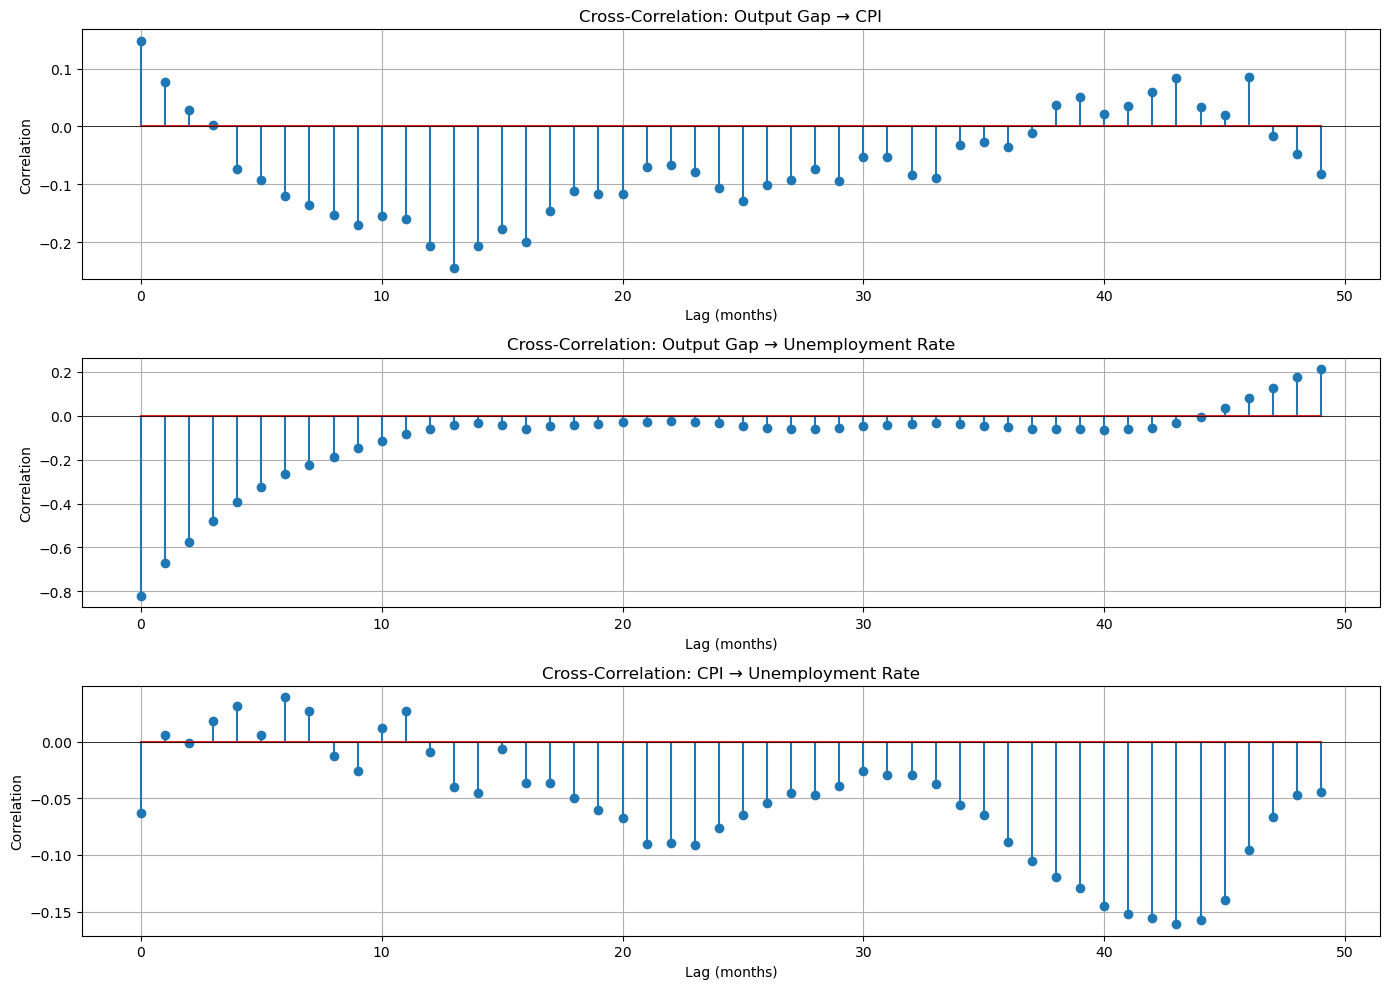

In [6]:
from statsmodels.tsa.stattools import ccf

# 准备数据
x1 = df_monthly['Output_Gap_z'] - df_monthly['Output_Gap_z'].mean()
y1 = df_monthly['CPI_z'] - df_monthly['CPI_z'].mean()
x2 = df_monthly['Output_Gap_z'] - df_monthly['Output_Gap_z'].mean()
y2 = df_monthly['Unemployment_Rate_z'] - df_monthly['Unemployment_Rate_z'].mean()
x3 = df_monthly['CPI_z'] - df_monthly['CPI_z'].mean()
y3 = df_monthly['Unemployment_Rate_z'] - df_monthly['Unemployment_Rate_z'].mean()

ccf1 = ccf(x1, y1)
ccf2 = ccf(x2, y2)
ccf3 = ccf(x3, y3)

# 绘图
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.stem(range(len(ccf1[:50])), ccf1[:50])
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Cross-Correlation: Output Gap → CPI')
plt.xlabel('Lag (months)')
plt.ylabel('Correlation')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.stem(range(len(ccf2[:50])), ccf2[:50])
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Cross-Correlation: Output Gap → Unemployment Rate')
plt.xlabel('Lag (months)')
plt.ylabel('Correlation')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.stem(range(len(ccf3[:50])), ccf3[:50])
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Cross-Correlation: CPI → Unemployment Rate')
plt.xlabel('Lag (months)')
plt.ylabel('Correlation')
plt.grid(True)

plt.tight_layout()
plt.show()

🔍 Top 2 Peak Frequencies and Corresponding Periods:
Peak 1: Frequency = 0.0254, Amplitude = 78.7225, Period = 39.43 time units
Peak 2: Frequency = 0.0072, Amplitude = 77.3389, Period = 138.00 time units


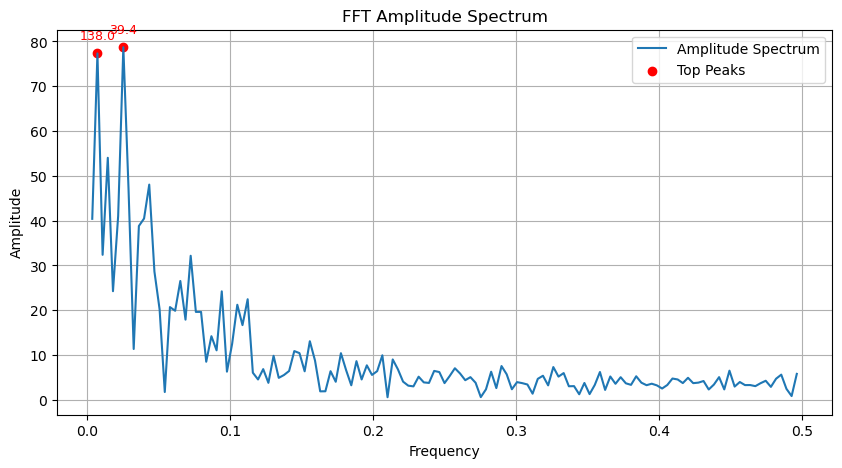

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Fourier Transform
x = df_monthly['Output_Gap_z'].dropna().values
n = len(x)
fft_result = np.fft.fft(x)
freqs = np.fft.fftfreq(n)

# 只取前一半正频率部分（跳过频率=0项）
positive_freqs = freqs[1:n//2]
amplitudes = np.abs(fft_result[1:n//2])  # 跳过 DC 成分（频率=0）

# 找出前两个最大的峰值的索引
top_two_idx = np.argpartition(amplitudes, -2)[-2:]
top_two_idx = top_two_idx[np.argsort(amplitudes[top_two_idx])[::-1]]  # 降序排序

# 输出两个峰的信息
print("🔍 Top 2 Peak Frequencies and Corresponding Periods:")
for i, idx in enumerate(top_two_idx):
    freq = positive_freqs[idx]
    amp = amplitudes[idx]
    period = 1 / freq if freq != 0 else np.inf
    print(f"Peak {i+1}: Frequency = {freq:.4f}, Amplitude = {amp:.4f}, Period = {period:.2f} time units")

# 可视化
plt.figure(figsize=(10, 5))
plt.plot(positive_freqs, amplitudes, label='Amplitude Spectrum')
plt.scatter(positive_freqs[top_two_idx], amplitudes[top_two_idx], color='red', label='Top Peaks')

for idx in top_two_idx:
    plt.annotate(f"{1/positive_freqs[idx]:.1f}", 
                 (positive_freqs[idx], amplitudes[idx]), 
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color='red')

plt.title("FFT Amplitude Spectrum")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


/opt/anaconda3/envs/gdp_env/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/envs/gdp_env/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/envs/gdp_env/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/envs/gdp_env/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/envs/gdp_env/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC A

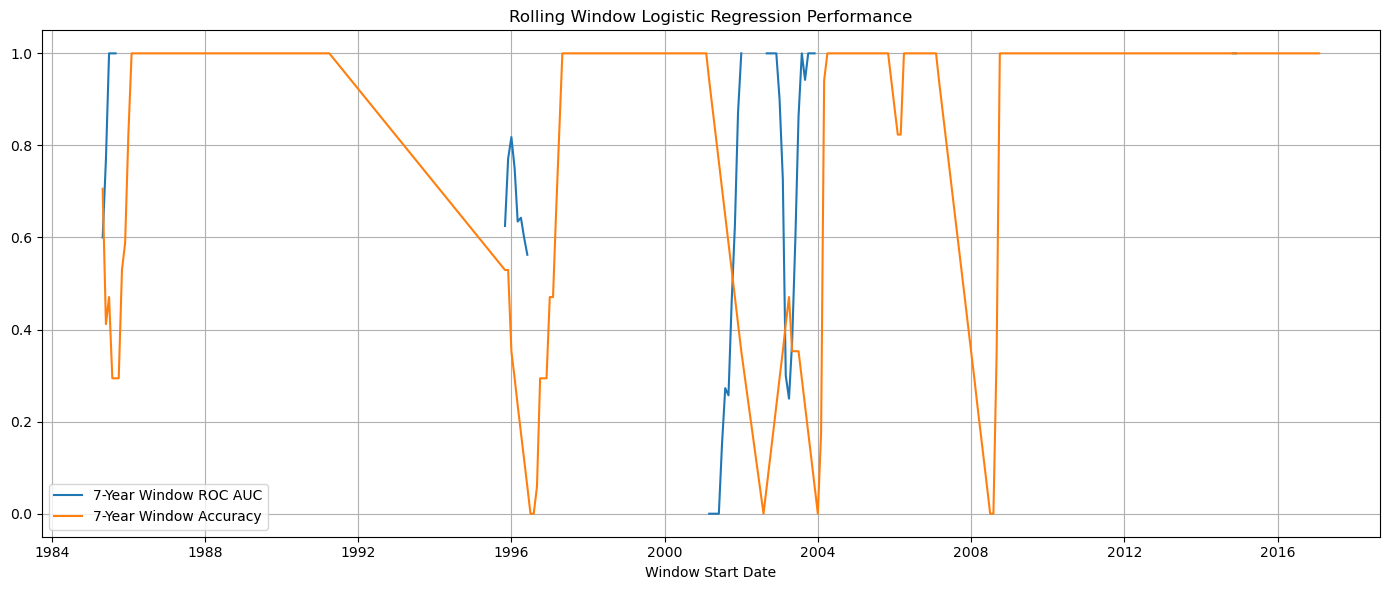

In [8]:
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# 1. 下载数据
start_date = '1985-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

actual_gdp = pdr.DataReader('GDPC1', 'fred', start_date, end_date)
potential_gdp = pdr.DataReader('GDPPOT', 'fred', start_date, end_date)
unrate = pdr.DataReader('UNRATE', 'fred', start_date, end_date)
cpi = pdr.DataReader('CPALTT01USM657N', 'fred', start_date, end_date)
nber_recession = pdr.DataReader('USREC', 'fred', start_date, end_date)

# 2. 合并数据
df = pd.concat([actual_gdp, potential_gdp, unrate, cpi, nber_recession], axis=1)
df.columns = ['Actual_GDP', 'Potential_GDP', 'Unemployment_Rate', 'CPI', 'Recession']
df['Output_Gap'] = 100 * (df['Actual_GDP'] - df['Potential_GDP']) / df['Potential_GDP']
df = df.dropna()

# 3. 转为月度数据，缺失值前向填充
df_monthly = df.resample('M').ffill()

# 4. 滚动窗口评估函数
def rolling_window_evaluation(df, window_months=84):
    results = []
    for start in range(len(df) - window_months):
        window_data = df.iloc[start:start+window_months]
        X = window_data[['Output_Gap', 'Unemployment_Rate', 'CPI']]
        y = window_data['Recession']
        
        split_idx = int(len(window_data) * 0.8)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
        
        # 跳过训练集中只有一个类别的窗口
        if y_train.nunique() < 2:
            continue
        
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)
        
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        auc = roc_auc_score(y_test, y_prob)
        accuracy = (y_pred == y_test).mean()
        
        results.append({
            'start_date': window_data.index[0],
            'end_date': window_data.index[-1],
            'roc_auc': auc,
            'accuracy': accuracy
        })
    return pd.DataFrame(results)

# 5. 执行滚动窗口评估（7年窗口）
results_7y = rolling_window_evaluation(df_monthly, window_months=84)

# 6. 结果可视化
plt.figure(figsize=(14,6))
plt.plot(results_7y['start_date'], results_7y['roc_auc'], label='7-Year Window ROC AUC')
plt.plot(results_7y['start_date'], results_7y['accuracy'], label='7-Year Window Accuracy')
plt.xlabel('Window Start Date')
plt.title('Rolling Window Logistic Regression Performance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


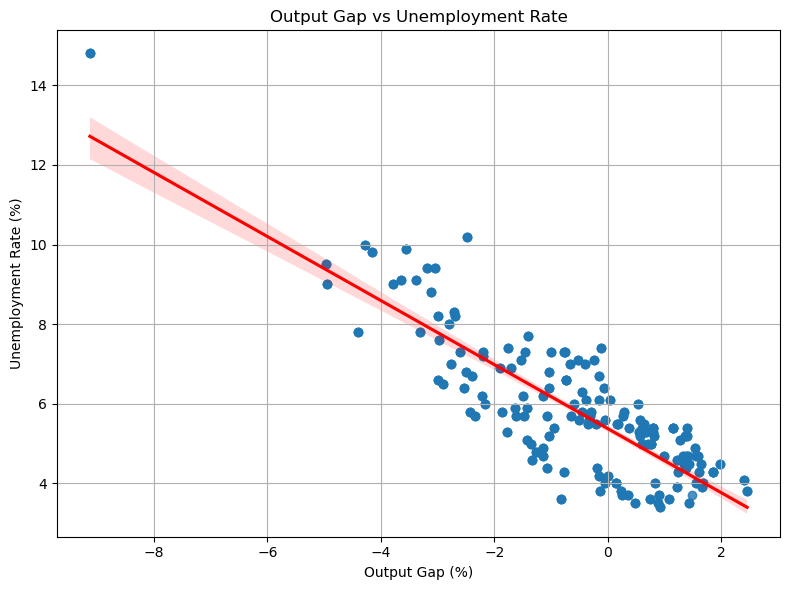

皮尔森相关系数: -0.833, P值: 3.9e-122
线性回归：失业率 = 5.375 + -0.805 * Output Gap
R² = 0.694


In [9]:
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import numpy as np

# 去掉 NaN（保险做法）
analysis_df = df_monthly[['Output_Gap', 'Unemployment_Rate']].dropna()

# 1. 散点图
plt.figure(figsize=(8, 6))
sns.regplot(data=analysis_df, x='Output_Gap', y='Unemployment_Rate', line_kws={"color": "red"})
plt.title('Output Gap vs Unemployment Rate')
plt.xlabel('Output Gap (%)')
plt.ylabel('Unemployment Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 相关系数
corr_value, p_value = pearsonr(analysis_df['Output_Gap'], analysis_df['Unemployment_Rate'])
print(f"皮尔森相关系数: {corr_value:.3f}, P值: {p_value:.3g}")

# 3. 简单线性回归
X = analysis_df['Output_Gap'].values.reshape(-1, 1)
y = analysis_df['Unemployment_Rate'].values
model = LinearRegression().fit(X, y)
print(f"线性回归：失业率 = {model.intercept_:.3f} + {model.coef_[0]:.3f} * Output Gap")
print(f"R² = {model.score(X, y):.3f}")


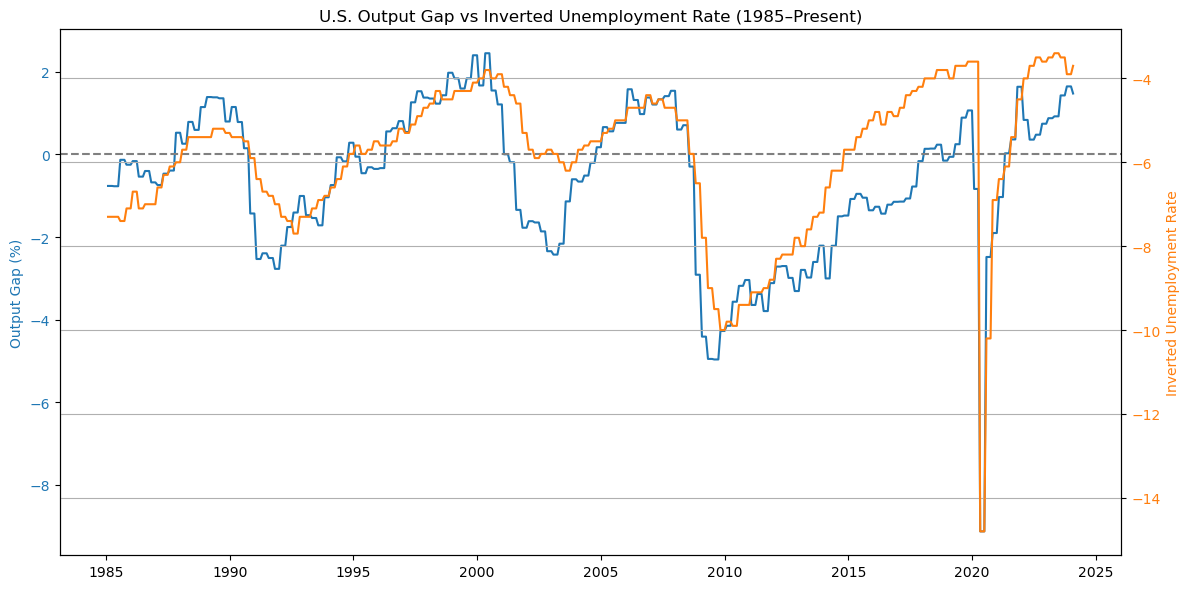

In [10]:
# 翻转失业率：方法1：取反
df_monthly['Inverted_Unrate'] = -df_monthly['Unemployment_Rate']

# 方法2（更直观）：最大值减去当前值
# max_unrate = df_monthly['Unemployment_Rate'].max()
# df_monthly['Inverted_Unrate'] = max_unrate - df_monthly['Unemployment_Rate']

# 可视化：双轴图（含翻转失业率）
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Output Gap 曲线（左轴）
ax1.plot(df_monthly.index, df_monthly['Output_Gap'], label='Output Gap (%)', color='tab:blue')
ax1.set_ylabel('Output Gap (%)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.axhline(0, color='gray', linestyle='--')

# 失业率翻转后曲线（右轴）
ax2.plot(df_monthly.index, df_monthly['Inverted_Unrate'], label='Inverted Unemployment Rate', color='tab:orange')
ax2.set_ylabel('Inverted Unemployment Rate', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('U.S. Output Gap vs Inverted Unemployment Rate (1985–Present)')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()


截距（β0）：5.3747
回归系数（β1）：-0.8045
模型R²：0.6939


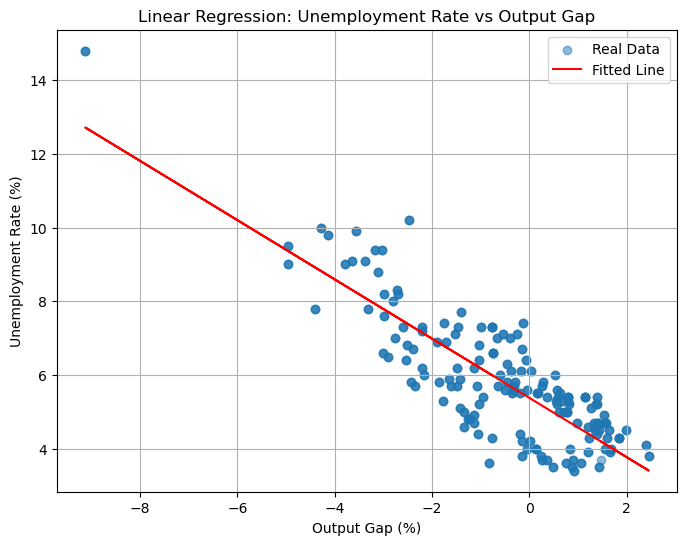

In [11]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 假设df_monthly已包含Output_Gap和Unemployment_Rate，且无缺失值
df_reg = df_monthly[['Output_Gap', 'Unemployment_Rate']].dropna()

# 准备特征X和目标y
X = df_reg['Output_Gap'].values.reshape(-1, 1)  # sklearn需要二维数组
y = df_reg['Unemployment_Rate'].values

# 建立线性回归模型
model = LinearRegression()
model.fit(X, y)

# 输出回归结果
print(f"截距（β0）：{model.intercept_:.4f}")
print(f"回归系数（β1）：{model.coef_[0]:.4f}")
print(f"模型R²：{model.score(X, y):.4f}")

# 预测值
y_pred = model.predict(X)

# 绘制回归散点图与拟合直线
plt.figure(figsize=(8,6))
plt.scatter(X, y, alpha=0.5, label='Real Data')
plt.plot(X, y_pred, color='red', label='Fitted Line')
plt.xlabel('Output Gap (%)')
plt.ylabel('Unemployment Rate (%)')
plt.title('Linear Regression: Unemployment Rate vs Output Gap')
plt.legend()
plt.grid(True)
plt.show()


              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97        36
         1.0       0.00      0.00      0.00         1

    accuracy                           0.95        37
   macro avg       0.49      0.49      0.49        37
weighted avg       0.95      0.95      0.95        37

混淆矩阵:
 [[35  1]
 [ 1  0]]
ROC AUC: 0.08333333333333337


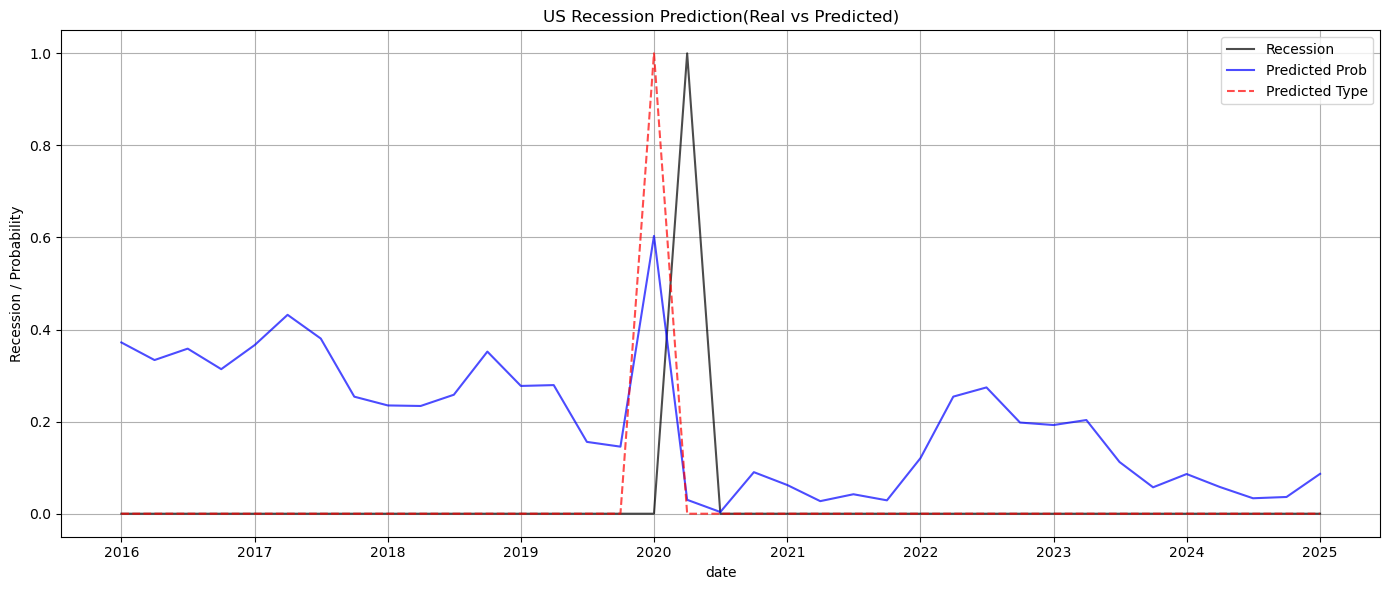

/opt/anaconda3/envs/gdp_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/gdp_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


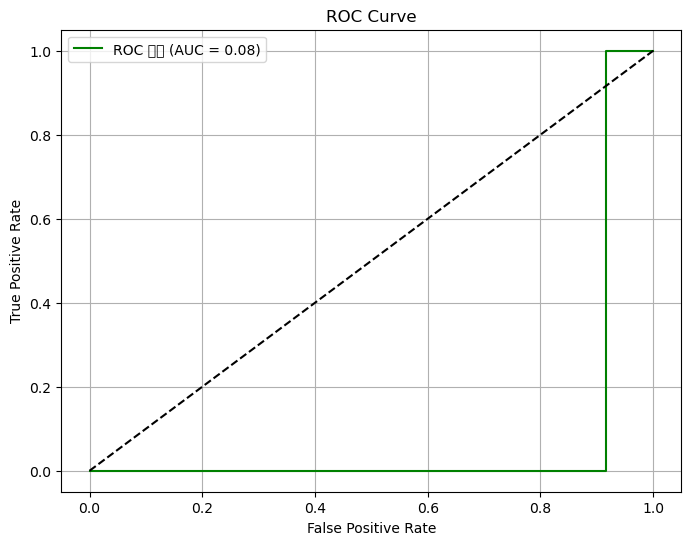

In [12]:
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# 1. 获取数据
start_date = '1985-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

actual_gdp = pdr.DataReader('GDPC1', 'fred', start_date, end_date)
potential_gdp = pdr.DataReader('GDPPOT', 'fred', start_date, end_date)
unrate = pdr.DataReader('UNRATE', 'fred', start_date, end_date)
nber_recession = pdr.DataReader('USREC', 'fred', start_date, end_date)

# 2. 合并数据
df = pd.concat([actual_gdp, potential_gdp, unrate, nber_recession], axis=1)
df.columns = ['Actual_GDP', 'Potential_GDP', 'Unemployment_Rate', 'Recession']
df['Output_Gap'] = 100 * (df['Actual_GDP'] - df['Potential_GDP']) / df['Potential_GDP']
df = df.dropna()

# 3. 划分训练测试集
train = df.loc[:'2015-12-31']
test = df.loc['2016-01-01':]

X_train = train[['Output_Gap', 'Unemployment_Rate']]
y_train = train['Recession']
X_test = test[['Output_Gap', 'Unemployment_Rate']]
y_test = test['Recession']

# 4. 训练逻辑回归
model = LogisticRegression()
model.fit(X_train, y_train)

# 5. 预测概率和类别
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# 6. 评估打印
print(classification_report(y_test, y_pred))
print('混淆矩阵:\n', confusion_matrix(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_prob))

# 7. 可视化真实与预测衰退区间概率和预测结果
plt.figure(figsize=(14,6))

plt.plot(test.index, y_test, label='Recession', color='black', linestyle='-', alpha=0.7)
plt.plot(test.index, y_prob, label='Predicted Prob', color='blue', alpha=0.7)
plt.plot(test.index, y_pred, label='Predicted Type', color='red', linestyle='--', alpha=0.7)

plt.title('US Recession Prediction(Real vs Predicted)')
plt.xlabel('date')
plt.ylabel('Recession / Probability')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. ROC曲线
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC 曲线 (AUC = {roc_auc_score(y_test, y_prob):.2f})', color='green')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


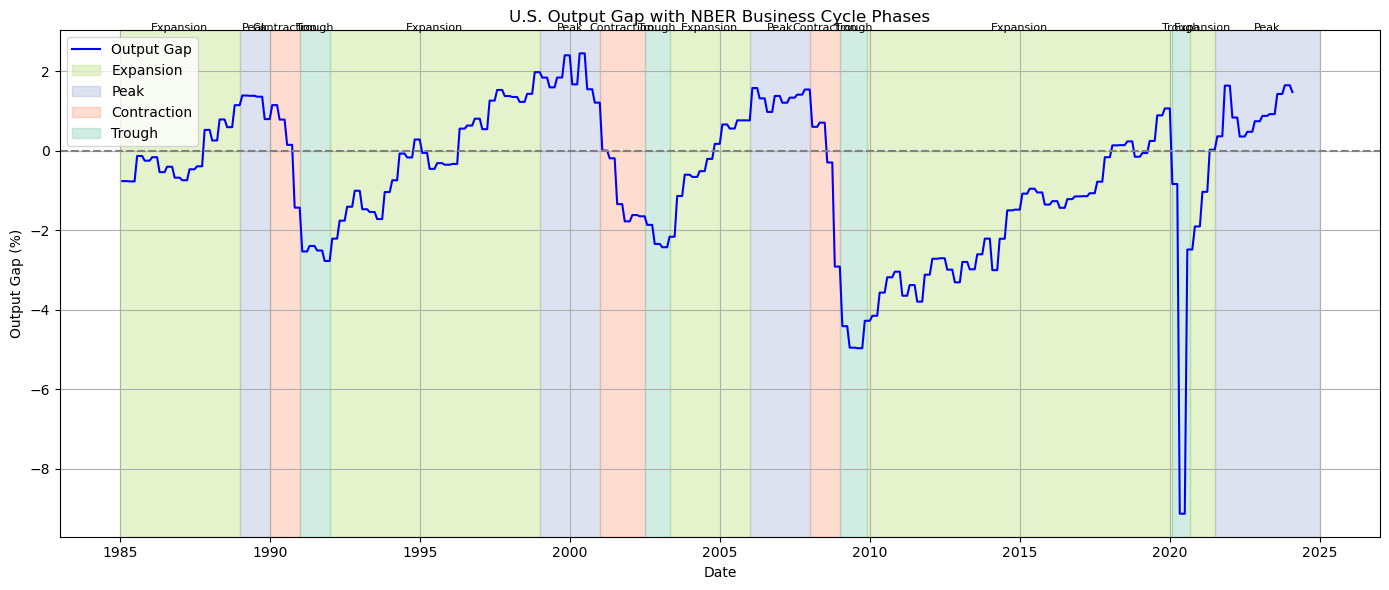

In [13]:
plt.figure(figsize=(14, 6))
plt.plot(df_monthly.index, df_monthly["Output_Gap"], label="Output Gap", color="blue")
plt.axhline(0, color="gray", linestyle="--")
nber_cycles = [
    ("1985-01", "1989-01", "Expansion"),
    ("1989-01", "1990-01", "Peak"),
    ("1990-01", "1991-01", "Contraction"),
    ("1991-01", "1992-01", "Trough"),

    ("1992-01", "1999-01", "Expansion"),
    ("1999-01", "2001-01", "Peak"),
    ("2001-01", "2002-07", "Contraction"),
    ("2002-07", "2003-05", "Trough"),

    ("2003-05", "2006-01", "Expansion"),
    ("2006-01", "2008-01", "Peak"),
    ("2008-01", "2009-01", "Contraction"),
    ("2009-01", "2009-12", "Trough"),
    
    ("2009-12", "2020-02", "Expansion"),
    ("2020-02", "2020-09", "Trough"),
    ("2020-09", "2021-07", "Expansion"),
    ("2021-07", "2025-01", "Peak"),

]
cycle_colors = {
    "Expansion": "#a6d854",
    "Contraction": "#fc8d62",
    "Peak": "#8da0cb",
    "Trough": "#66c2a5" 
}

for start, end, label in nber_cycles:
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    plt.axvspan(start_date, end_date, color=cycle_colors[label], alpha=0.3,
                label=label if plt.gca().get_legend_handles_labels()[1].count(label) == 0 else None)
    plt.text((start_date + (end_date - start_date) / 2), df_monthly["Output_Gap"].max() + 0.5,
             label, ha="center", va="bottom", fontsize=8)

plt.title("U.S. Output Gap with NBER Business Cycle Phases")
plt.xlabel("Date")
plt.ylabel("Output Gap (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
import pandas as pd
from collections import defaultdict

# === Step 1: Load EPS data ===

df_eps = pd.read_excel("Top_20_US_Companies_EPS.xlsx")
df_eps['Date'] = pd.to_datetime('1899-12-30') + pd.to_timedelta(df_eps['Dates'], unit='D')
df_eps = df_eps.drop(columns='Dates').set_index('Date')

# === Step 2: Load sector mapping ===
df_sector = pd.read_excel("Top_20_US_Companies_By_Sector_With_Bloomberg_Tickers.xlsx")
ticker_to_sector = dict(zip(df_sector['Bloomberg_Ticker'], df_sector['Sector']))

# === Step 3: Define business cycle phases ===
business_cycles = [
    ("1985-01", "1989-01", "Expansion"),
    ("1989-01", "1990-01", "Peak"),
    ("1990-01", "1991-01", "Contraction"),
    ("1991-01", "1992-01", "Trough"),
    ("1992-01", "1999-01", "Expansion"),
    ("1999-01", "2001-01", "Peak"),
    ("2001-01", "2002-07", "Contraction"),
    ("2002-07", "2003-03", "Trough"),
    ("2003-03", "2006-01", "Expansion"),
    ("2006-01", "2008-01", "Peak"),
    ("2008-01", "2009-01", "Contraction"),
    ("2009-01", "2009-12", "Trough"),
    ("2009-12", "2020-02", "Expansion"),
    ("2020-02", "2020-09", "Trough"),
    ("2020-09", "2021-07", "Expansion"),
    ("2021-07", "2025-01", "Peak"),
]

# === Step 4: Group periods by phase ===
phase_periods = defaultdict(list)
for start, end, phase in business_cycles:
    phase_periods[phase].append((pd.to_datetime(start), pd.to_datetime(end)))

# === Step 5: Compute average EPS for each sector and cycle phase ===
final_results = []

for phase, periods in phase_periods.items():
    # Merge time periods within the same phase
    df_phase = pd.DataFrame()
    for start_date, end_date in periods:
        df_slice = df_eps[(df_eps.index >= start_date) & (df_eps.index < end_date)]
        df_phase = pd.concat([df_phase, df_slice])

    # Calculate sector-level average EPS
    sector_eps = defaultdict(list)
    for ticker in df_phase.columns:
        sector = ticker_to_sector.get(ticker)
        if sector:
            sector_eps[sector].append(df_phase[ticker])

    for sector, eps_series in sector_eps.items():
        combined = pd.concat(eps_series, axis=1)
        avg_eps = combined.mean(axis=1, skipna=True).mean(skipna=True)
        if pd.notna(avg_eps):
            final_results.append({
                "Sector": sector,
                "Cycle_Phase": phase,
                "Average_EPS": avg_eps
            })

# === Step 6: Save or print results ===
df_result = pd.DataFrame(final_results)
print(df_result)
# df_result.to_excel("Sector_EPS_by_Cycle.xlsx", index=False)

                    Sector  Cycle_Phase  Average_EPS
0   Information Technology    Expansion     0.377949
1              Health Care    Expansion     0.725625
2               Financials    Expansion     1.337286
3   Communication Services    Expansion     0.146357
4   Consumer Discretionary    Expansion     1.063776
5         Consumer Staples    Expansion     0.543520
6                   Energy    Expansion     0.403222
7              Industrials    Expansion     0.907293
8                Materials    Expansion     0.621465
9              Real Estate    Expansion     0.417614
10               Utilities    Expansion     0.474361
11  Information Technology         Peak     0.722737
12             Health Care         Peak     1.364802
13              Financials         Peak     2.395394
14  Communication Services         Peak     0.222839
15  Consumer Discretionary         Peak     2.445370
16        Consumer Staples         Peak     0.711067
17                  Energy         Peak     1.

In [15]:
# Step 1: 聚合（防止重复组合）
df_cleaned = df_result.groupby(["Sector", "Cycle_Phase"]).mean(numeric_only=True).reset_index()

# Step 2: Pivot 成行业 × 周期的结构
df_pivot = df_cleaned.pivot(index="Sector", columns="Cycle_Phase", values="Average_EPS")

# Step 3: 按你希望的顺序排列列
df_pivot = df_pivot[["Expansion", "Peak", "Contraction", "Trough"]]

# Step 4: 输出结果（可视化或保存）
print(df_pivot)

Cycle_Phase             Expansion      Peak  Contraction    Trough
Sector                                                            
Communication Services   0.146357  0.222839    -0.864942 -0.077588
Consumer Discretionary   1.063776  2.445370     0.170262  1.733276
Consumer Staples         0.543520  0.711067     0.335613  0.409108
Energy                   0.403222  1.501020     0.381152 -0.439363
Financials               1.337286  2.395394    -2.107126  0.747365
Health Care              0.725625  1.364802     0.253083  0.589745
Industrials              0.907293  1.483599     0.425254  0.461442
Information Technology   0.377949  0.722737     0.118438  0.187876
Materials                0.621465  0.913508     0.283431  0.372082
Real Estate              0.417614  0.649510     0.250533  0.401601
Utilities                0.474361  0.618444     0.399680  0.394564


In [16]:
# 设置时间区间
start_date = '1985-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# === 1. M2 YoY 增速 ===
m2 = pdr.DataReader('M2SL', 'fred', start_date, end_date)
m2_yoy = m2.pct_change(periods=12) * 100
m2_yoy.rename(columns={'M2SL': 'M2_YoY'}, inplace=True)

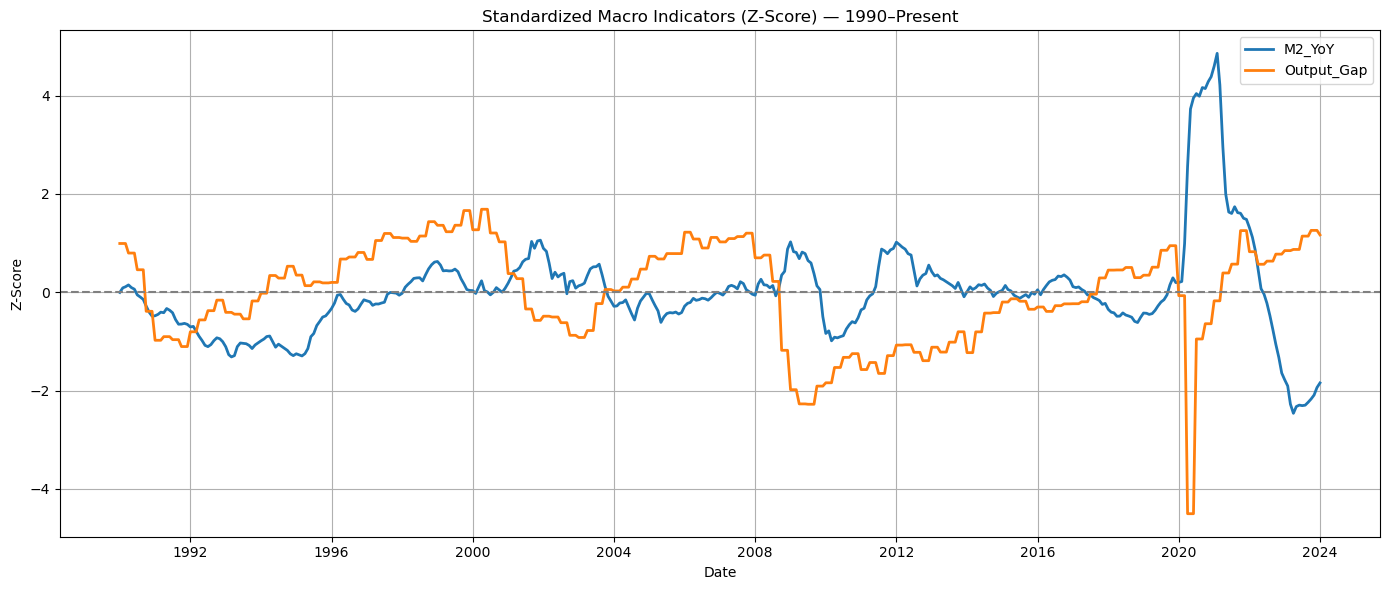

In [17]:
m2_yoy.index = m2_yoy.index.to_period('M').to_timestamp()
df_monthly.index = df_monthly.index.to_period('M').to_timestamp()  # 你原来的 Output Gap

df_all = pd.concat([
    m2_yoy,
    df_monthly[['Output_Gap']]
], axis=1)

df_all = df_all.loc['1990-01-01':]

df_clean = df_all.dropna()
df_standardized = (df_clean - df_clean.mean()) / df_clean.std()

plt.figure(figsize=(14, 6))
for col in df_standardized.columns:
    plt.plot(df_standardized.index, df_standardized[col], label=col, linewidth=2)

plt.title("Standardized Macro Indicators (Z-Score) — 1990–Present")
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.axhline(0, linestyle='--', color='gray')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### S&P 500 Index

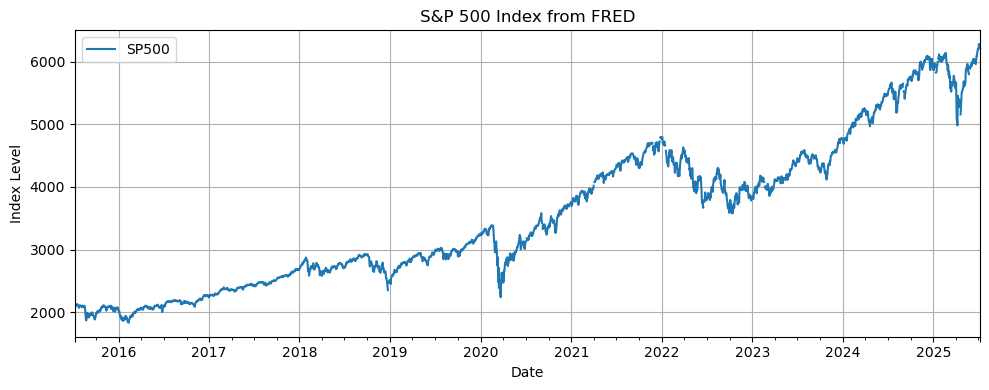

In [34]:
import pandas_datareader.data as pdr
from datetime import datetime
import matplotlib.pyplot as plt

# 设置时间范围
start = '1985-01-01'
end = datetime.today().strftime('%Y-%m-%d')

# 从 FRED 获取 S&P 500 指数（注意：这是月度数据）
sp500 = pdr.DataReader('SP500', 'fred', start, end)

# 可视化
sp500.plot(title='S&P 500 Index from FRED', figsize=(10, 4))
plt.grid(True)
plt.ylabel("Index Level")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


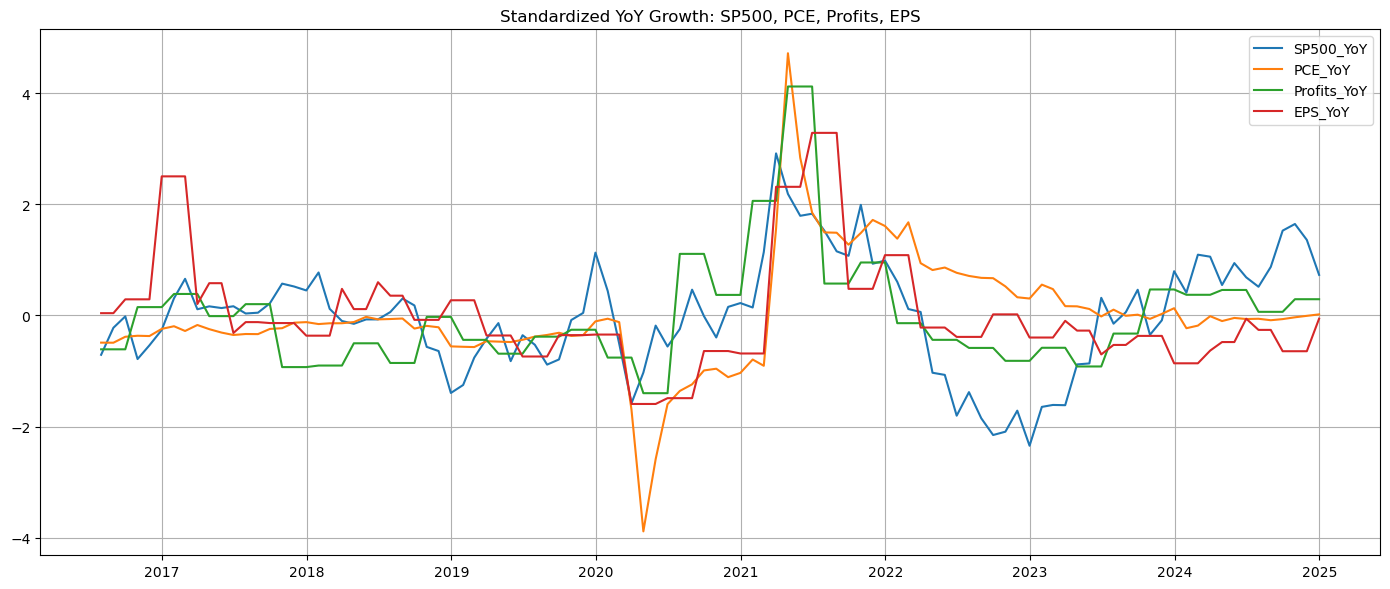

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr

# === 1. 时间设置 ===
start_date = '1985-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# === 2. 从 FRED 获取数据 ===
sp500 = pdr.DataReader('SP500', 'fred', start_date, end_date)
pce = pdr.DataReader('PCE', 'fred', start_date, end_date)
profits = pdr.DataReader('CP', 'fred', start_date, end_date)

# === 3. 重采样为月度 ===
sp500 = sp500.resample('M').last()
pce = pce.resample('M').last()
profits = profits.resample('M').last()

# === 4. 构造 EPS 月度数据 ===
# 假设 df_eps 已经在内存中
df_eps_monthly = df_eps.resample('M').mean()  # 所有公司简单平均
df_eps_monthly['EPS'] = df_eps_monthly.mean(axis=1)

# === 5. 构建主分析表 ===
df = pd.DataFrame(index=sp500.index)
df['SP500_YoY'] = sp500.pct_change(12) * 100
df['PCE_YoY'] = pce.pct_change(12) * 100
df['Profits_YoY'] = profits.pct_change(12) * 100
df['EPS_YoY'] = df_eps_monthly['EPS'].pct_change(12) * 100

# === 6. 清洗 + 标准化 ===
df_clean = df.dropna()
df_std = (df_clean - df_clean.mean()) / df_clean.std()

# === 7. 可视化：标准化趋势 ===
plt.figure(figsize=(14, 6))
for col in df_std.columns:
    plt.plot(df_std.index, df_std[col], label=col)
plt.legend()
plt.title("Standardized YoY Growth: SP500, PCE, Profits, EPS")
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
# === 8. 同期相关性 ===
corr_same = df_clean.corr()
print("【同期相关性矩阵】")
print(corr_same)

# === 9. 滞后相关性：PCE、Profits、EPS 滞后 12 个月 vs SP500 ===
df_lagged = df_clean.copy()
df_lagged['PCE_YoY_lag12'] = df_lagged['PCE_YoY'].shift(12)
df_lagged['Profits_YoY_lag12'] = df_lagged['Profits_YoY'].shift(12)
df_lagged['EPS_YoY_lag12'] = df_lagged['EPS_YoY'].shift(12)

lag_corr = df_lagged[['SP500_YoY', 'PCE_YoY_lag12', 'Profits_YoY_lag12', 'EPS_YoY_lag12']].dropna().corr()
print("\n【滞后相关性矩阵（滞后12个月）】")
print(lag_corr)

【同期相关性矩阵】
             SP500_YoY   PCE_YoY  Profits_YoY   EPS_YoY
SP500_YoY     1.000000  0.340541     0.599959  0.381982
PCE_YoY       0.340541  1.000000     0.514355  0.642562
Profits_YoY   0.599959  0.514355     1.000000  0.479462
EPS_YoY       0.381982  0.642562     0.479462  1.000000

【滞后相关性矩阵（滞后12个月）】
                   SP500_YoY  PCE_YoY_lag12  Profits_YoY_lag12  EPS_YoY_lag12
SP500_YoY           1.000000      -0.639963          -0.217187      -0.519996
PCE_YoY_lag12      -0.639963       1.000000           0.521523       0.650402
Profits_YoY_lag12  -0.217187       0.521523           1.000000       0.513905
EPS_YoY_lag12      -0.519996       0.650402           0.513905       1.000000


The S&P 500 is an index, or a group of stocks that share one or more common traits. In this case, those shared characteristics include a high number of readily tradeable shares and size—the index is made up of stocks from about 500 of the US’s largest companies. (As of January 2025, there are about 500 companies represented in the index, but this is subject to change.) Because these stocks come from sectors across the market, changes to the index’s value could tell you a lot about the performance of the stock market as a whole. The S&P 500’s value is determined by the combined average performance of the stocks within the index, with more weight given to larger companies. When the S&P 500’s value rises, that means enough stocks increased in value enough to bring up the total average value.

| Variable                  | Relationship to S\&P 500                     | Timing             |
| ------------------------- | -------------------------------------------- | ------------------ |
| **EPS YoY**               | Positive correlation; key driver             | Leading/Concurrent |
| **Corporate Profits YoY** | Positive correlation; supports EPS and price | Leading/Concurrent |
| **PCE YoY**               | Positive correlation; consumer-led earnings  | Leading/Concurrent |


### Consumer Expectation Index

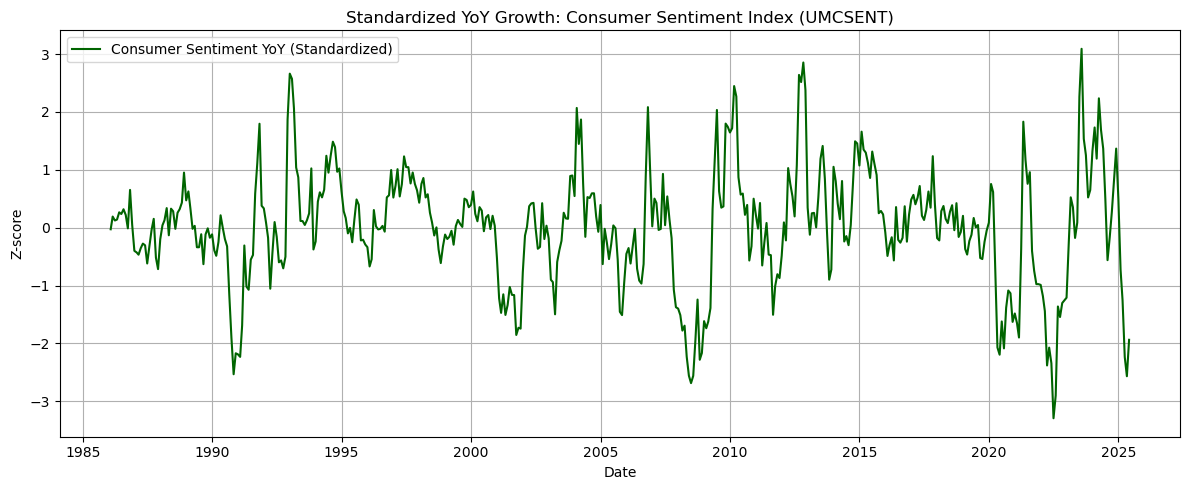

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr

# === 1. 获取 UMCSENT ===
start_date = '1985-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

umcsent = pdr.DataReader('UMCSENT', 'fred', start_date, end_date)
umcsent = umcsent.resample('M').last()

# === 2. 计算同比增速（YoY）并标准化 ===
df = pd.DataFrame(index=umcsent.index)
df['UMCSENT_YoY'] = umcsent.pct_change(12) * 100
df_clean = df.dropna()
df_std = (df_clean - df_clean.mean()) / df_clean.std()

# === 3. 绘图 ===
plt.figure(figsize=(12, 5))
plt.plot(df_std.index, df_std['UMCSENT_YoY'], label='Consumer Sentiment YoY (Standardized)', color='darkgreen')
plt.title("Standardized YoY Growth: Consumer Sentiment Index (UMCSENT)")
plt.xlabel("Date")
plt.ylabel("Z-score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

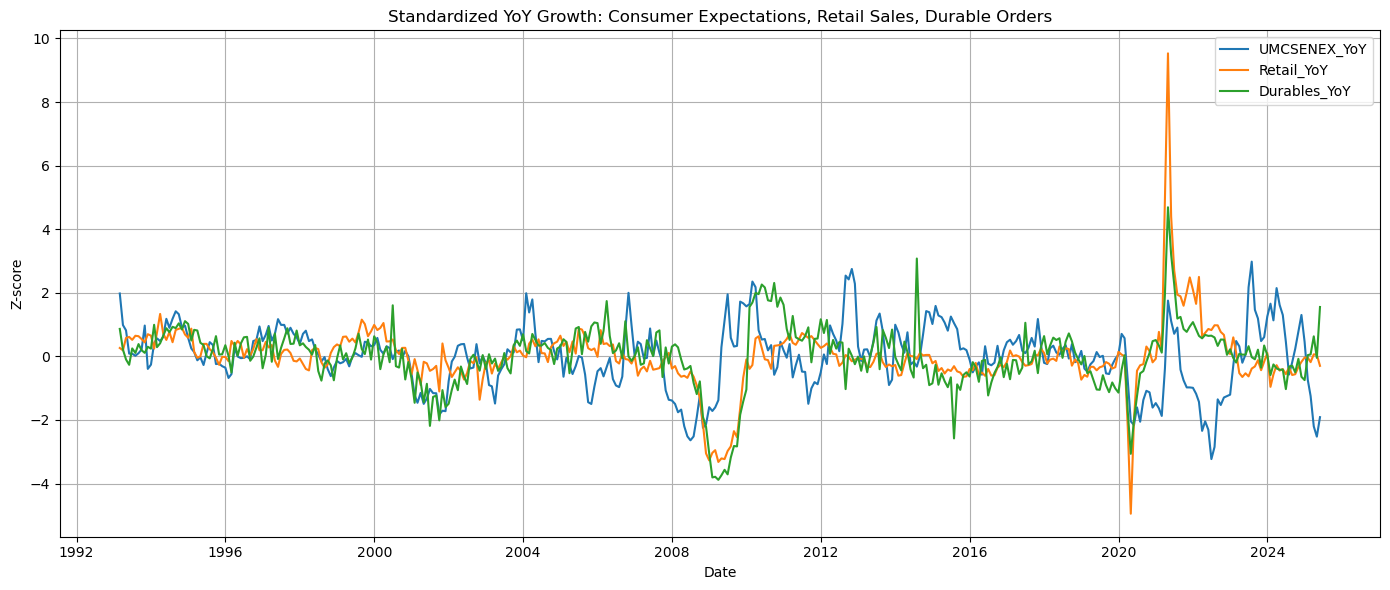

【同期相关性矩阵】
              UMCSENEX_YoY  Retail_YoY  Durables_YoY
UMCSENEX_YoY      1.000000    0.105143      0.140565
Retail_YoY        0.105143    1.000000      0.730711
Durables_YoY      0.140565    0.730711      1.000000

【滞后相关性矩阵（Retail / Durables 滞后12个月 vs UMCSENEX 当前）】
                    UMCSENEX_YoY  Retail_YoY_lag12  Durables_YoY_lag12
UMCSENEX_YoY            1.000000         -0.264620           -0.186409
Retail_YoY_lag12       -0.264620          1.000000            0.734797
Durables_YoY_lag12     -0.186409          0.734797            1.000000


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr

# === 1. 时间设置 ===
start_date = '1985-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# === 2. 下载数据 ===
umcsenex = pdr.DataReader('UMCSENT', 'fred', start_date, end_date)  # 消费者预期
retail = pdr.DataReader('RSAFS', 'fred', start_date, end_date)       # 零售销售
durables = pdr.DataReader('DGORDER', 'fred', start_date, end_date)   # 耐用品订单

# === 3. 重采样为月度（保险处理）===
umcsenex = umcsenex.resample('M').last()
retail = retail.resample('M').last()
durables = durables.resample('M').last()

# === 4. 构建主表 & 同比增速计算 ===
df = pd.DataFrame(index=umcsenex.index)
df['UMCSENEX_YoY'] = umcsenex.pct_change(12) * 100
df['Retail_YoY'] = retail.pct_change(12) * 100
df['Durables_YoY'] = durables.pct_change(12) * 100

# === 5. 清洗缺失值 ===
df_clean = df.dropna()
df_std = (df_clean - df_clean.mean()) / df_clean.std()

# === 6. 标准化趋势可视化 ===
plt.figure(figsize=(14, 6))
for col in df_std.columns:
    plt.plot(df_std.index, df_std[col], label=col)
plt.title("Standardized YoY Growth: Consumer Expectations, Retail Sales, Durable Orders")
plt.xlabel("Date")
plt.ylabel("Z-score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 7. 同期相关性矩阵 ===
print("【同期相关性矩阵】")
print(df_clean.corr())

# === 8. 滞后相关性（滞后12个月 vs UMCSENEX）===
df_lagged = df_clean.copy()
df_lagged['Retail_YoY_lag12'] = df_lagged['Retail_YoY'].shift(12)
df_lagged['Durables_YoY_lag12'] = df_lagged['Durables_YoY'].shift(12)

lag_corr = df_lagged[['UMCSENEX_YoY', 'Retail_YoY_lag12', 'Durables_YoY_lag12']].dropna().corr()
print("\n【滞后相关性矩阵（Retail / Durables 滞后12个月 vs UMCSENEX 当前）】")
print(lag_corr)


### Average Weekly Hours

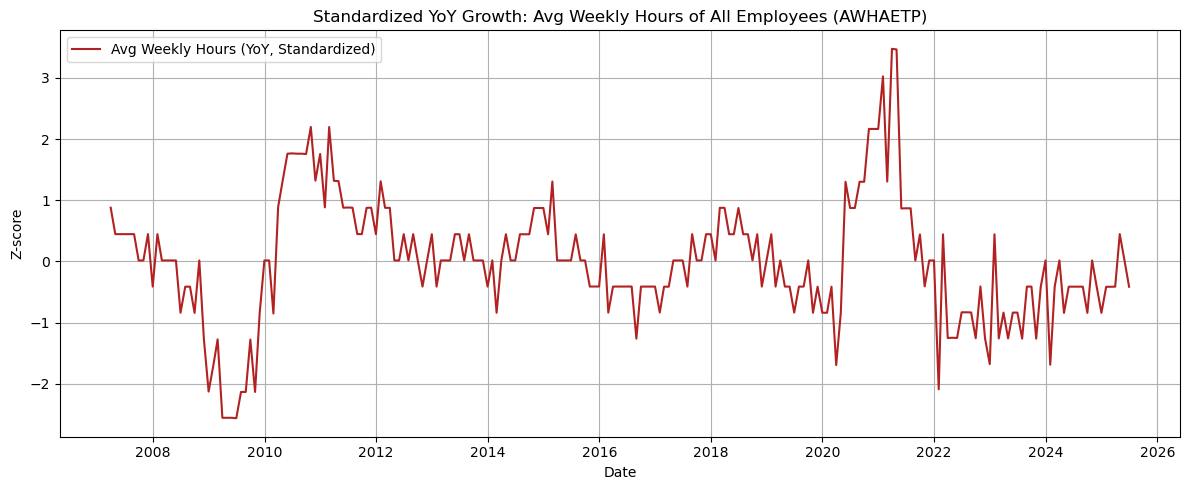

【AWHAETP：当前与滞后12个月的自相关】
                   AWHAETP_YoY  AWHAETP_YoY_lag12
AWHAETP_YoY           1.000000          -0.181755
AWHAETP_YoY_lag12    -0.181755           1.000000


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr

# === 1. 获取 AWHAETP 数据 ===
start_date = '1985-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

awh = pdr.DataReader('AWHAETP', 'fred', start_date, end_date)
awh = awh.resample('M').last()

# === 2. 计算同比增速（YoY）并标准化 ===
df = pd.DataFrame(index=awh.index)
df['AWHAETP_YoY'] = awh.pct_change(12) * 100
df_clean = df.dropna()
df_std = (df_clean - df_clean.mean()) / df_clean.std()

# === 3. 绘图：标准化 YoY 曲线 ===
plt.figure(figsize=(12, 5))
plt.plot(df_std.index, df_std['AWHAETP_YoY'], label='Avg Weekly Hours (YoY, Standardized)', color='firebrick')
plt.title("Standardized YoY Growth: Avg Weekly Hours of All Employees (AWHAETP)")
plt.xlabel("Date")
plt.ylabel("Z-score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === 4. 滞后自相关（lag-12）分析 ===
df_lagged = df_clean.copy()
df_lagged['AWHAETP_YoY_lag12'] = df_lagged['AWHAETP_YoY'].shift(12)
corr_matrix = df_lagged[['AWHAETP_YoY', 'AWHAETP_YoY_lag12']].dropna().corr()

print("【AWHAETP：当前与滞后12个月的自相关】")
print(corr_matrix)


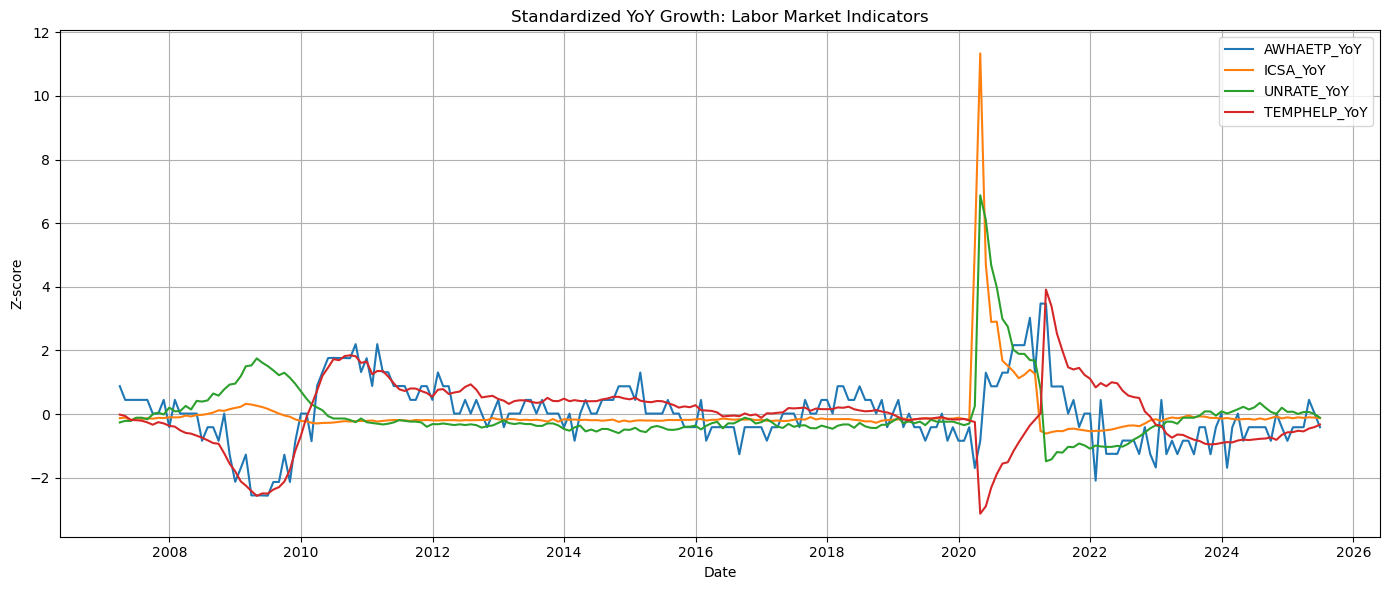

【同期相关性矩阵】
              AWHAETP_YoY  ICSA_YoY  UNRATE_YoY  TEMPHELP_YoY
AWHAETP_YoY      1.000000  0.003699   -0.013845      0.515930
ICSA_YoY         0.003699  1.000000    0.788258     -0.439709
UNRATE_YoY      -0.013845  0.788258    1.000000     -0.720781
TEMPHELP_YoY     0.515930 -0.439709   -0.720781      1.000000

【滞后相关性矩阵（其他变量滞后12个月 vs AWHAETP）】
                    AWHAETP_YoY  ICSA_YoY_lag12  UNRATE_YoY_lag12  \
AWHAETP_YoY            1.000000        0.324426          0.280819   
ICSA_YoY_lag12         0.324426        1.000000          0.789700   
UNRATE_YoY_lag12       0.280819        0.789700          1.000000   
TEMPHELP_YoY_lag12    -0.153317       -0.448980         -0.725633   

                    TEMPHELP_YoY_lag12  
AWHAETP_YoY                  -0.153317  
ICSA_YoY_lag12               -0.448980  
UNRATE_YoY_lag12             -0.725633  
TEMPHELP_YoY_lag12            1.000000  


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr

# === 1. 获取 FRED 数据 ===
start_date = '1985-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

awh = pdr.DataReader('AWHAETP', 'fred', start_date, end_date)
icsa = pdr.DataReader('ICSA', 'fred', start_date, end_date)
unrate = pdr.DataReader('UNRATE', 'fred', start_date, end_date)
temphelp = pdr.DataReader('TEMPHELPS', 'fred', start_date, end_date)

# === 2. 转换为月度数据 ===
awh = awh.resample('M').last()
icsa = icsa.resample('M').mean()       # 失业申请是周频 → 月平均
unrate = unrate.resample('M').last()
temphelp = temphelp.resample('M').last()

# === 3. 计算同比增速（YoY）===
df = pd.DataFrame(index=awh.index)
df['AWHAETP_YoY'] = awh.pct_change(12) * 100
df['ICSA_YoY'] = icsa.pct_change(12) * 100
df['UNRATE_YoY'] = unrate.pct_change(12) * 100
df['TEMPHELP_YoY'] = temphelp.pct_change(12) * 100

# === 4. 清洗 + 标准化 ===
df_clean = df.dropna()
df_std = (df_clean - df_clean.mean()) / df_clean.std()

# === 5. 可视化：Z-score 并列曲线图 ===
plt.figure(figsize=(14, 6))
for col in df_std.columns:
    plt.plot(df_std.index, df_std[col], label=col)
plt.title("Standardized YoY Growth: Labor Market Indicators")
plt.xlabel("Date")
plt.ylabel("Z-score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 6. 同期相关性 ===
print("【同期相关性矩阵】")
print(df_clean.corr())

# === 7. 滞后相关性（与 AWHAETP 滞后12月比较）===
df_lag = df_clean.copy()
for var in ['ICSA_YoY', 'UNRATE_YoY', 'TEMPHELP_YoY']:
    df_lag[var + '_lag12'] = df_lag[var].shift(12)

lag_corr = df_lag[['AWHAETP_YoY', 'ICSA_YoY_lag12', 'UNRATE_YoY_lag12', 'TEMPHELP_YoY_lag12']].dropna().corr()

print("\n【滞后相关性矩阵（其他变量滞后12个月 vs AWHAETP）】")
print(lag_corr)


### Vendor Performance

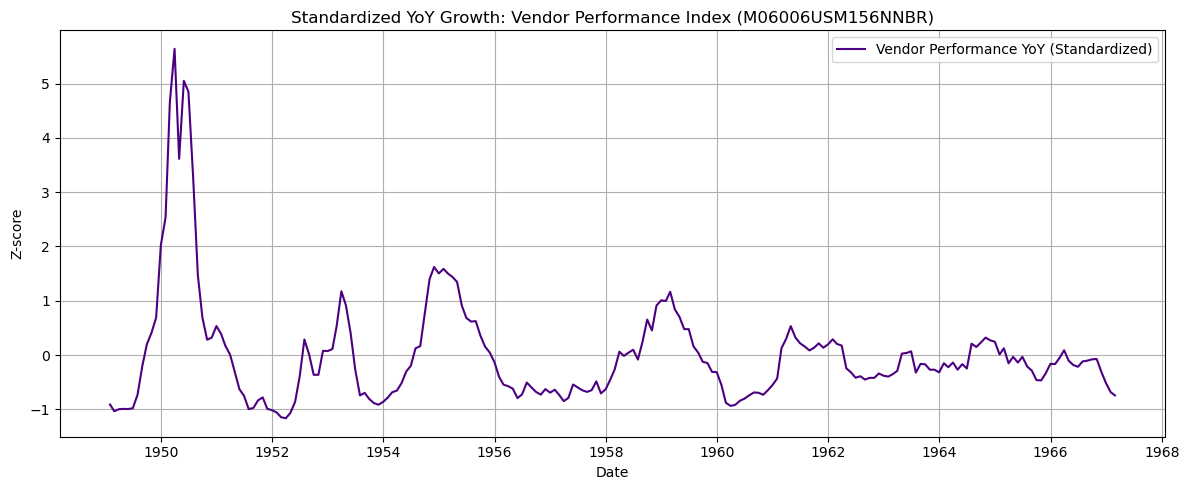

【Vendor Performance：当前与滞后12个月的自相关】
                  Vendor_YoY  Vendor_YoY_lag12
Vendor_YoY          1.000000         -0.292855
Vendor_YoY_lag12   -0.292855          1.000000


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr

# === 1. 获取 Vendor Performance 数据（单位为%）===
start_date = '1948-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

vendor = pdr.DataReader('M06006USM156NNBR', 'fred', start_date, end_date)
vendor = vendor.resample('M').last()  # 有些月份缺失，需要补成月频

# === 2. 计算同比增速（单位已是百分比，不乘100）===
df = pd.DataFrame(index=vendor.index)
df['Vendor_YoY'] = vendor.pct_change(12)

# === 3. 清洗 + 标准化 ===
df_clean = df.dropna()
df_std = (df_clean - df_clean.mean()) / df_clean.std()

# === 4. 绘图：标准化趋势 ===
plt.figure(figsize=(12, 5))
plt.plot(df_std.index, df_std['Vendor_YoY'], label='Vendor Performance YoY (Standardized)', color='indigo')
plt.title("Standardized YoY Growth: Vendor Performance Index (M06006USM156NNBR)")
plt.xlabel("Date")
plt.ylabel("Z-score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === 5. 滞后 12 个月自相关 ===
df_lagged = df_clean.copy()
df_lagged['Vendor_YoY_lag12'] = df_lagged['Vendor_YoY'].shift(12)

print("【Vendor Performance：当前与滞后12个月的自相关】")
print(df_lagged[['Vendor_YoY', 'Vendor_YoY_lag12']].dropna().corr())


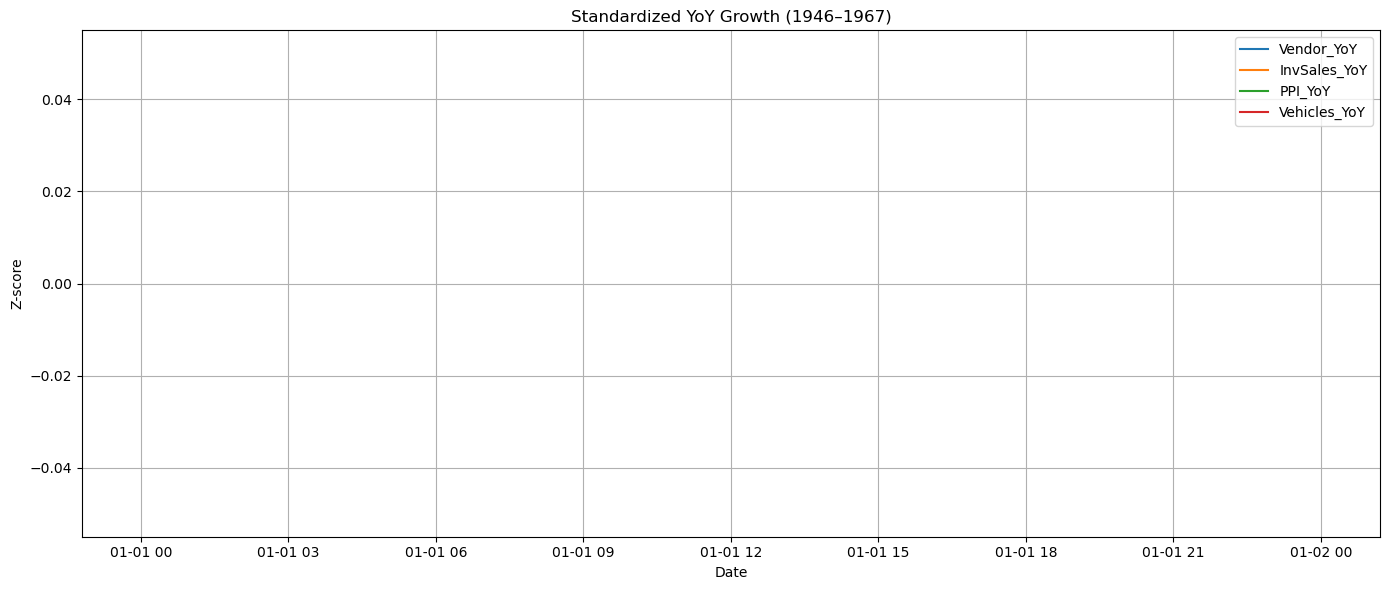

【同期相关性矩阵】
              Vendor_YoY  InvSales_YoY  PPI_YoY  Vehicles_YoY
Vendor_YoY           NaN           NaN      NaN           NaN
InvSales_YoY         NaN           NaN      NaN           NaN
PPI_YoY              NaN           NaN      NaN           NaN
Vehicles_YoY         NaN           NaN      NaN           NaN

【滞后12个月相关性矩阵】
                    Vendor_YoY  InvSales_YoY_lag12  PPI_YoY_lag12  \
Vendor_YoY                 NaN                 NaN            NaN   
InvSales_YoY_lag12         NaN                 NaN            NaN   
PPI_YoY_lag12              NaN                 NaN            NaN   
Vehicles_YoY_lag12         NaN                 NaN            NaN   

                    Vehicles_YoY_lag12  
Vendor_YoY                         NaN  
InvSales_YoY_lag12                 NaN  
PPI_YoY_lag12                      NaN  
Vehicles_YoY_lag12                 NaN  


In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

# 1. 设置时间范围
start_date = '1946-01-01'
end_date = '1967-12-31'

# 2. 获取数据（Vendor, Inventory/Sales, PPI, Durable Vehicle Output）
vendor = pdr.DataReader('M06006USM156NNBR', 'fred', start_date, end_date)       # Vendor Performance
inv_sales = pdr.DataReader('MNFCTRIRSA', 'fred', start_date, end_date)    # Inventory/Sales Ratio
ppi = pdr.DataReader('PCUAWHLTRAWHLTR', 'fred', start_date, end_date)          # Wholesale Price Index
vehicles = pdr.DataReader('IPG3366S', 'fred', start_date, end_date)             # Durable Goods: Motor Vehicles

# 3. 重采样为月度
vendor = vendor.resample('M').last()
inv_sales = inv_sales.resample('M').last()
ppi = ppi.resample('M').last()
vehicles = vehicles.resample('M').last()

# 4. 计算同比增速（YoY）
df = pd.DataFrame(index=vendor.index)
df['Vendor_YoY'] = vendor.pct_change(12)
df['InvSales_YoY'] = inv_sales.pct_change(12)
df['PPI_YoY'] = ppi.pct_change(12)
df['Vehicles_YoY'] = vehicles.pct_change(12)

# 5. 清洗缺失值 + 标准化
df_clean = df.dropna()
df_std = (df_clean - df_clean.mean()) / df_clean.std()

# 6. 绘制标准化趋势图
plt.figure(figsize=(14, 6))
for col in df_std.columns:
    plt.plot(df_std.index, df_std[col], label=col)
plt.title("Standardized YoY Growth (1946–1967)")
plt.xlabel("Date")
plt.ylabel("Z‑score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. 同期相关性矩阵
print("【同期相关性矩阵】")
print(df_clean.corr())

# 8. 滞后相关性矩阵（其他变量滞后12个月 vs Vendor 当前）
df_lag = df_clean.copy()
for var in ['InvSales_YoY', 'PPI_YoY', 'Vehicles_YoY']:
    df_lag[f'{var}_lag12'] = df_lag[var].shift(12)

lag_corr = df_lag[['Vendor_YoY',
                   'InvSales_YoY_lag12',
                   'PPI_YoY_lag12',
                   'Vehicles_YoY_lag12']].dropna().corr()

print("\n【滞后12个月相关性矩阵】")
print(lag_corr)


In [72]:
print(df.isna().mean())


Vendor_YoY       1.0000
Inventory_YoY    0.0300
Import_YoY       0.0075
dtype: float64


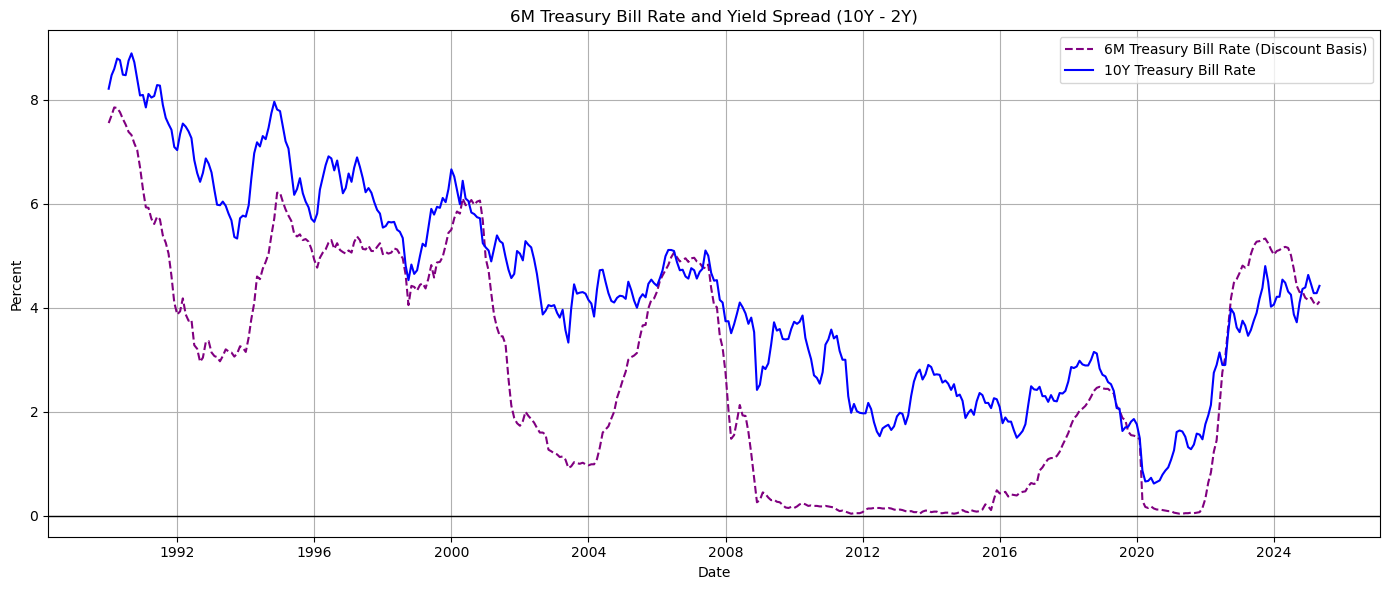

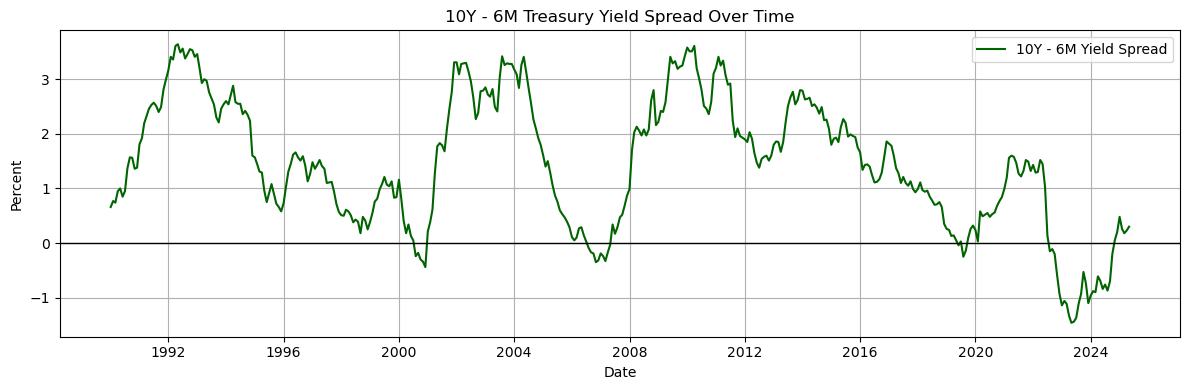

In [18]:
df_tb = pd.read_csv("fredgraph.csv")

df_tb.columns = df_tb.columns.str.strip()
df_tb = df_tb.rename(columns={
    'observation_date': 'Date',
    'DGS10': 'TBill_10Y',
    'DTB6': 'TBill_6M'
})


df_tb['Date'] = pd.to_datetime(df_tb['Date'])

df_tb['10Y_minus_6M'] = df_tb['TBill_10Y'] - df_tb['TBill_6M']

df_tb['Date'] = pd.to_datetime(df_tb['Date'])
#figure 1
plt.figure(figsize=(14, 6))
plt.plot(df_tb['Date'], df_tb['TBill_6M'], label='6M Treasury Bill Rate (Discount Basis)', linestyle='--', color='purple')
plt.plot(df_tb['Date'], df_tb['TBill_10Y'], label='10Y Treasury Bill Rate', color='blue')
plt.axhline(0, color='black', linewidth=1)
plt.title("6M Treasury Bill Rate and Yield Spread (10Y - 2Y)")
plt.ylabel("Percent")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
#figure2
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(df_tb['Date'], df_tb['10Y_minus_6M'], label='10Y - 6M Yield Spread', color='darkgreen')
plt.axhline(0, color='black', linewidth=1)
plt.title("10Y - 6M Treasury Yield Spread Over Time")
plt.xlabel("Date")
plt.ylabel("Percent")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

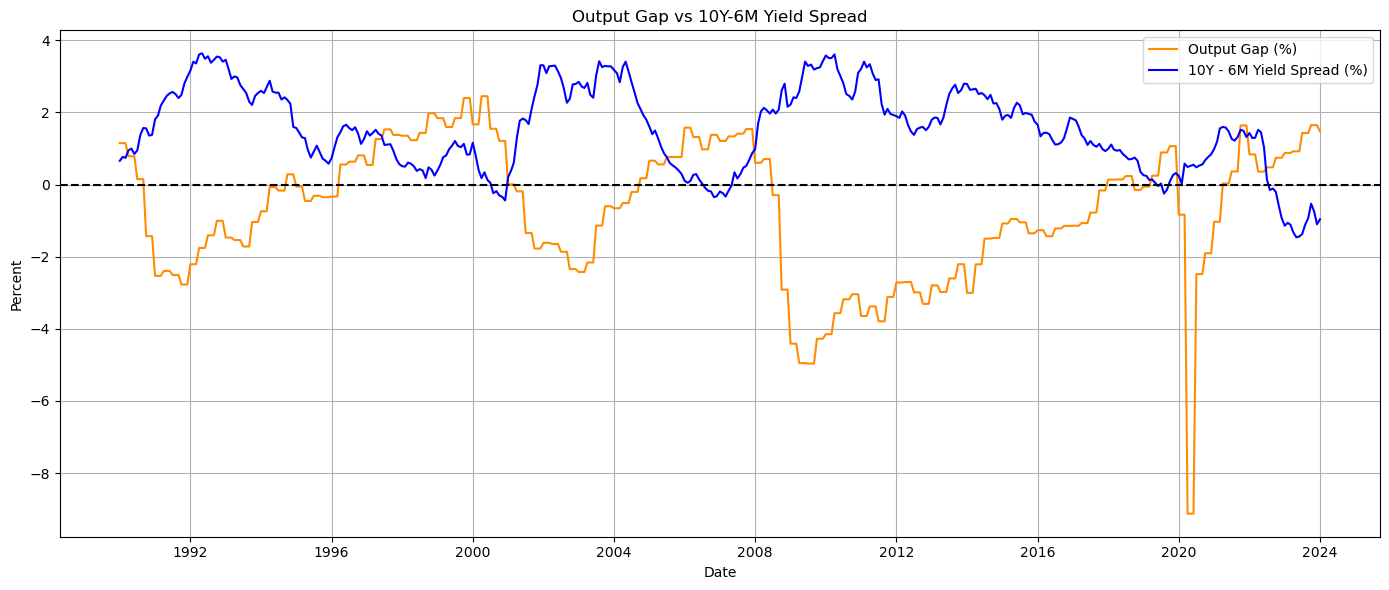

In [19]:

df_tb['Date'] = pd.to_datetime(df_tb['Date'])
df_tb = df_tb.set_index('Date')
df_plot = pd.concat([df_monthly[['Output_Gap']], df_tb[['10Y_minus_6M']]], axis=1)
df_plot = df_plot.dropna()

# plot
plt.figure(figsize=(14, 6))
plt.plot(df_plot.index, df_plot['Output_Gap'], label='Output Gap (%)', color='darkorange')
plt.plot(df_plot.index, df_plot['10Y_minus_6M'], label='10Y - 6M Yield Spread (%)', color='blue')
plt.axhline(0, color='black', linestyle='--')
plt.title("Output Gap vs 10Y-6M Yield Spread")
plt.xlabel("Date")
plt.ylabel("Percent")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
df_tb['10Y_minus_6M_lag1'] = df_tb['10Y_minus_6M'].shift(1)
df_all['M2_YoY_lag1'] = df_all['M2_YoY'].shift(1)
df_all = df_all.merge(
    df_tb[['10Y_minus_6M', '10Y_minus_6M_lag1']],
    left_index=True, right_index=True, how='left'
)

[[ 48   3]
 [  0 111]]
              precision    recall  f1-score   support

           0      1.000     0.941     0.970        51
           1      0.974     1.000     0.987       111

    accuracy                          0.981       162
   macro avg      0.987     0.971     0.978       162
weighted avg      0.982     0.981     0.981       162



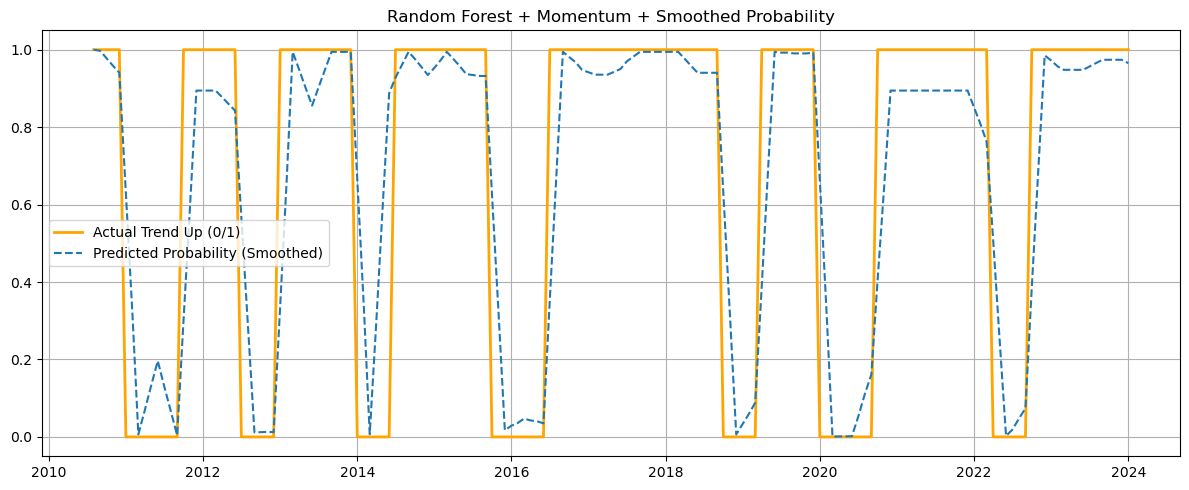

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
df_all['Gap_6M_before'] = df_all['Output_Gap'].shift(6)
df_all['Gap_6M_change'] = df_all['Output_Gap'] - df_all['Gap_6M_before']
df_all['Trend_Label'] = (df_all['Gap_6M_change'] > 0).astype(int)

df_all['OG_Mom_3M'] = df_all['Output_Gap'] - df_all['Output_Gap'].shift(3)
df_all['OG_Mom_6M'] = df_all['Output_Gap'] - df_all['Output_Gap'].shift(6)

X_cls = df_all[[
    '10Y_minus_6M_lag1',
    'M2_YoY_lag1',
    'OG_Mom_3M',
    'OG_Mom_6M'
]]
y_cls = df_all['Trend_Label']

# ==== date cleaning ====
df_cls = pd.concat([X_cls, y_cls], axis=1).dropna()
X_cls = df_cls.drop(columns='Trend_Label')
y_cls = df_cls['Trend_Label']

#split training/testing
split_idx = int(len(X_cls) * 0.6)
X_train, X_test = X_cls[:split_idx], X_cls[split_idx:]
y_train, y_test = y_cls[:split_idx], y_cls[split_idx:]
index_test = y_test.index

#training
clf = RandomForestClassifier(
    n_estimators=50,
    max_depth=3,
    class_weight='balanced',
    random_state=42
)
clf.fit(X_train, y_train)

#predicting
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]
y_prob_smooth = pd.Series(y_prob, index=index_test).rolling(3, min_periods=1).mean()

# ==== output ====
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

# ==== plot ====
plt.figure(figsize=(12, 5))
plt.plot(index_test, y_test.values, label='Actual Trend Up (0/1)', color='orange', linewidth=2)
plt.plot(index_test, y_prob_smooth, label='Predicted Probability (Smoothed)', linestyle='--')
plt.title('Random Forest + Momentum + Smoothed Probability')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [22]:

df_etf = pd.read_excel("ETF list.xlsx", header=[0, 1])
df_etf.columns = [' '.join(col).strip() for col in df_etf.columns]

df_etf.head()

,Unnamed: 0_level_0 Dates,XLK US Equity PX_LAST,XLC US Equity PX_LAST,XLV US Equity PX_LAST,XLF US Equity PX_LAST,XLY US Equity PX_LAST,XLP US Equity PX_LAST,XLE US Equity PX_LAST,XLI US Equity PX_LAST,XLU US Equity PX_LAST,XLRE US Equity PX_LAST,XLB US Equity PX_LAST
0,32932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,32962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,32993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,33024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,33053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:

df_etf.rename(columns={"Unnamed: 0_level_0 Dates": "Date"}, inplace=True)
df_etf.head()

,Date,XLK US Equity PX_LAST,XLC US Equity PX_LAST,XLV US Equity PX_LAST,XLF US Equity PX_LAST,XLY US Equity PX_LAST,XLP US Equity PX_LAST,XLE US Equity PX_LAST,XLI US Equity PX_LAST,XLU US Equity PX_LAST,XLRE US Equity PX_LAST,XLB US Equity PX_LAST
0,32932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,32962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,32993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,33024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,33053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
if pd.api.types.is_numeric_dtype(df_etf["Date"]):
    df_etf["Date"] = pd.to_datetime(df_etf["Date"], origin="1899-12-30", unit="D")
else:
    df_etf["Date"] = pd.to_datetime(df_etf["Date"], errors="coerce")

df_etf.head()

,Date,XLK US Equity PX_LAST,XLC US Equity PX_LAST,XLV US Equity PX_LAST,XLF US Equity PX_LAST,XLY US Equity PX_LAST,XLP US Equity PX_LAST,XLE US Equity PX_LAST,XLI US Equity PX_LAST,XLU US Equity PX_LAST,XLRE US Equity PX_LAST,XLB US Equity PX_LAST
0,1990-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1990-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1990-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1990-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:

df_etf = df_etf[df_etf["Date"] > pd.to_datetime("1998-12-31")]


print(df_etf.head())

          Date  XLK US Equity PX_LAST  XLC US Equity PX_LAST  \
107 1999-01-29                37.8125                    NaN   
108 1999-02-26                34.0625                    NaN   
109 1999-03-31                36.5938                    NaN   
110 1999-04-30                36.8125                    NaN   
111 1999-05-31                36.9375                    NaN   

     XLV US Equity PX_LAST  XLF US Equity PX_LAST  XLY US Equity PX_LAST  \
107                27.2500                19.3615                27.4688   
108                27.2813                19.6660                27.2969   
109                28.0000                20.2497                28.5938   
110                29.0000                21.6707                29.3438   
111                28.1094                20.3639                28.0156   

     XLP US Equity PX_LAST  XLE US Equity PX_LAST  XLI US Equity PX_LAST  \
107                26.7969                21.8125                24.2969   
108   

In [26]:
df_etf["Date"] = pd.to_datetime(df_etf["Date"], errors="coerce")

df_etf["Date"] = df_etf["Date"] + pd.offsets.MonthEnd(1)

df_etf["Date"] = df_etf["Date"].apply(lambda x: x.replace(day=1) if pd.notna(x) else x)

df_etf = df_etf[df_etf["Date"].notna()]

print(df_etf)

          Date  XLK US Equity PX_LAST  XLC US Equity PX_LAST  \
107 1999-01-01                37.8125                    NaN   
108 1999-02-01                34.0625                    NaN   
109 1999-04-01                36.5938                    NaN   
110 1999-05-01                36.8125                    NaN   
111 1999-06-01                36.9375                    NaN   
..         ...                    ...                    ...   
414 2024-08-01               220.3300                  87.32   
415 2024-10-01               225.7600                  90.40   
416 2024-11-01               222.2400                  92.04   
417 2024-11-01               233.7300                  98.40   
418 2025-01-01               232.5200                  96.81   

     XLV US Equity PX_LAST  XLF US Equity PX_LAST  XLY US Equity PX_LAST  \
107                27.2500                19.3615                27.4688   
108                27.2813                19.6660                27.2969   
109

In [27]:
df_etf = df_etf[df_etf["Date"].notna()]

df_etf.set_index("Date", inplace=True)

df_etf = df_etf[df_etf.index.isin(df_monthly.index)]

combined = df_monthly.join(df_etf, how="inner")
print(combined)

            Actual_GDP  Potential_GDP  Unemployment_Rate       CPI  Recession  \
1999-01-01   13315.597    13074.75048                4.3  0.244051        0.0   
1999-02-01   13315.597    13074.75048                4.3  0.244051        0.0   
1999-04-01   13426.748    13215.68444                4.3  0.727273        0.0   
1999-05-01   13426.748    13215.68444                4.3  0.727273        0.0   
1999-06-01   13426.748    13215.68444                4.3  0.727273        0.0   
...                ...            ...                ...       ...        ...   
2023-09-01   22780.933    22459.74068                3.5  0.190752        0.0   
2023-09-01   22780.933    22459.74068                3.5  0.190752        0.0   
2023-11-01   22960.600    22588.18459                3.9 -0.038338        0.0   
2023-12-01   22960.600    22588.18459                3.9 -0.038338        0.0   
2023-12-01   22960.600    22588.18459                3.9 -0.038338        0.0   

            Output_Gap  Inv

In [28]:
# 1. split Output Gap 
positive_gap = combined[combined["Output_Gap"] > 0]
negative_gap = combined[combined["Output_Gap"] < 0]

# 计算 Sharpe Ratio（平均收益 / 标准差）
sharpe_pos = positive_gap.iloc[:, 3:].pct_change().mean() / positive_gap.iloc[:, 3:].pct_change().std()
sharpe_neg = negative_gap.iloc[:, 3:].pct_change().mean() / negative_gap.iloc[:, 3:].pct_change().std()

# 取前3名表现最好 ETF
top_sharpe_pos = sharpe_pos.sort_values(ascending=False).head(3)
top_sharpe_neg = sharpe_neg.sort_values(ascending=False).head(3)

# 打印结果
print("📈 Output Gap 为正时 Sharpe 表现最好的 ETF：")
print(top_sharpe_pos)

print("\n📉 Output Gap 为负时 Sharpe 表现最好的 ETF：")
print(top_sharpe_neg)

📈 Output Gap 为正时 Sharpe 表现最好的 ETF：
XLE US Equity PX_LAST    0.187436
XLB US Equity PX_LAST    0.178485
XLI US Equity PX_LAST    0.155436
dtype: float64

📉 Output Gap 为负时 Sharpe 表现最好的 ETF：
XLC US Equity PX_LAST    0.330106
XLY US Equity PX_LAST    0.208117
XLV US Equity PX_LAST    0.201429
dtype: float64


In [29]:
import numpy as np
window = 6  
etf_cols = [col for col in combined.columns if col.endswith("PX_LAST")]


labels = []
for i in range(len(combined) - window + 1):
    gap_seg = combined['Output_Gap'].iloc[i:i+window]
    if gap_seg.is_monotonic_increasing:
        labels.append(1)
    elif gap_seg.is_monotonic_decreasing:
        labels.append(-1)
    else:
        labels.append(0)
combined['Gap_Trend_6M'] = [np.nan]*(window-1) + labels

# ===== calculate monthly return =====
returns = combined[etf_cols].pct_change()
combined[etf_cols] = returns

# ===== average return during upward/downward trend =====
rising = combined[combined['Gap_Trend_6M'] == 1]
falling = combined[combined['Gap_Trend_6M'] == -1]

rising_perf = rising[etf_cols].mean().sort_values(ascending=False)
falling_perf = falling[etf_cols].mean().sort_values(ascending=False)

# ===== output =====
print(" Top 3 performer during expasion ETF：")
print(rising_perf.head(3))

print(" Top 3 performer during recession ETF：")
print(falling_perf.head(3))

 Top 3 performer during expasion ETF：
XLK US Equity PX_LAST    0.018180
XLC US Equity PX_LAST    0.015596
XLY US Equity PX_LAST    0.014038
dtype: float64
 Top 3 performer during recession ETF：
XLV US Equity PX_LAST   -0.000633
XLY US Equity PX_LAST   -0.000964
XLB US Equity PX_LAST   -0.002183
dtype: float64


In [30]:
print(combined.columns)

Index(['Actual_GDP', 'Potential_GDP', 'Unemployment_Rate', 'CPI', 'Recession',
       'Output_Gap', 'Inverted_Unrate', 'XLK US Equity PX_LAST',
       'XLC US Equity PX_LAST', 'XLV US Equity PX_LAST',
       'XLF US Equity PX_LAST', 'XLY US Equity PX_LAST',
       'XLP US Equity PX_LAST', 'XLE US Equity PX_LAST',
       'XLI US Equity PX_LAST', 'XLU US Equity PX_LAST',
       'XLRE US Equity PX_LAST', 'XLB US Equity PX_LAST', 'Gap_Trend_6M'],
      dtype='object')


In [31]:
combined["Smoothed_Proba"] = y_prob_smooth
print(combined)

            Actual_GDP  Potential_GDP  Unemployment_Rate       CPI  Recession  \
1999-01-01   13315.597    13074.75048                4.3  0.244051        0.0   
1999-02-01   13315.597    13074.75048                4.3  0.244051        0.0   
1999-04-01   13426.748    13215.68444                4.3  0.727273        0.0   
1999-05-01   13426.748    13215.68444                4.3  0.727273        0.0   
1999-06-01   13426.748    13215.68444                4.3  0.727273        0.0   
...                ...            ...                ...       ...        ...   
2023-09-01   22780.933    22459.74068                3.5  0.190752        0.0   
2023-09-01   22780.933    22459.74068                3.5  0.190752        0.0   
2023-11-01   22960.600    22588.18459                3.9 -0.038338        0.0   
2023-12-01   22960.600    22588.18459                3.9 -0.038338        0.0   
2023-12-01   22960.600    22588.18459                3.9 -0.038338        0.0   

            Output_Gap  Inv

In [32]:
print(combined.head())

            Actual_GDP  Potential_GDP  Unemployment_Rate       CPI  Recession  \
1999-01-01   13315.597    13074.75048                4.3  0.244051        0.0   
1999-02-01   13315.597    13074.75048                4.3  0.244051        0.0   
1999-04-01   13426.748    13215.68444                4.3  0.727273        0.0   
1999-05-01   13426.748    13215.68444                4.3  0.727273        0.0   
1999-06-01   13426.748    13215.68444                4.3  0.727273        0.0   

            Output_Gap  Inverted_Unrate  XLK US Equity PX_LAST  \
1999-01-01    1.842074             -4.3                    NaN   
1999-02-01    1.842074             -4.3              -0.099174   
1999-04-01    1.597069             -4.3               0.074313   
1999-05-01    1.597069             -4.3               0.005976   
1999-06-01    1.597069             -4.3               0.003396   

            XLC US Equity PX_LAST  XLV US Equity PX_LAST  \
1999-01-01                    NaN                    NaN